In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [60]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

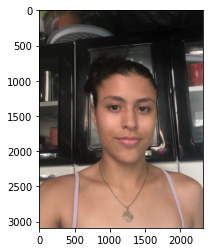

In [61]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('../input/selfies-id-images-dataset/11_sets_Hispanics/0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana/Selfie_9.jpg')
imgplot = plt.imshow(img)

In [62]:
img.shape

(3088, 2320, 3)

In [63]:
images = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        images.append(os.path.join(dirname, filename))
images = pd.DataFrame(images,columns=['filenames'])

In [64]:
images['given_names'] = images.filenames.apply(lambda x: x[x.find('name')+5:x.find('/',x.find('name')+5)])

In [65]:
images["image_type"] = images.filenames.apply(lambda x: x[x.find('/',x.find('name')+5)+1:x.find('_',x.find('name')+5)])

In [66]:
images

,filenames,given_names,image_type
0,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,Selfie
1,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,Selfie
2,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,Selfie
3,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,ID
4,/kaggle/input/selfies-id-images-dataset/11_set...,Matheus,Selfie
...,...,...,...
430,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie
431,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie
432,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie
433,/kaggle/input/selfies-id-images-dataset/18_set...,Anastasia,Selfie


In [67]:
def build_facematch_dataset(images,size=1000):
    X1_dataset = []
    X2_dataset = []
    y1_dataset = []
    y2_dataset = []
    for i in range(size):
        first_sample = np.random.randint(0,435)
        second_sample = np.random.randint(0,435)
        X1_dataset.append(images.filenames[first_sample])
        X2_dataset.append(images.filenames[second_sample])
        if images.given_names[first_sample] == images.given_names[second_sample]:
            y1_dataset.append(1)
        else:
            y1_dataset.append(0)
        if images.image_type[first_sample] == 'ID' and images.image_type[second_sample] == 'ID':
            y2_dataset.append(0)
        else:
            y2_dataset.append(1)
    
    labels = np.c_[y1_dataset,y2_dataset]
        
    return tf.data.Dataset.from_tensor_slices(({"input_1":X1_dataset,"input_2":X2_dataset},labels))

In [68]:
train = build_facematch_dataset(images,size=10000)
val = build_facematch_dataset(images,size=1000)
test = build_facematch_dataset(images,size=1000)

In [69]:
for i in train.take(1):
    print(i)

({'input_1': <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/selfies-id-images-dataset/11_sets_Hispanics/0001cc1e1e--61af8aa9d46ff461a71462cc_age_31_name_Daiane/Selfie_3.jpg'>, 'input_2': <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/selfies-id-images-dataset/18_sets_ Caucasians/0001ca9b9a--61af4a11ec7c4619a7c95ddf_age_18_name_Anastasia /Selfie_7.jpg'>}, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>)


In [70]:
def process_path(images,labels):
    raw1, raw2 = tf.io.read_file(images["input_1"]), tf.io.read_file(images["input_2"])
    image1, image2 = tf.image.decode_jpeg(raw1, channels=3), tf.image.decode_jpeg(raw2, channels=3)
    image1, image2 = tf.image.resize(image1, [14, 14]), tf.image.resize(image2, [14, 14])
    return {"input_1":image1,"input_2":image2},labels

In [71]:
train = train.map(process_path)
val = val.map(process_path)
test = test.map(process_path)

In [72]:
def scale_pixels(images,labels):
    image1, image2 = images['input_1'], images['input_2']
    image1 = (image1 - tf.reduce_mean(image1))/tf.math.reduce_std(image1)
    image2 = (image2 - tf.reduce_mean(image2))/tf.math.reduce_std(image2)
    return {"input_1":image1,"input_2":image2},labels

In [73]:
train = train.map(scale_pixels)
val = val.map(scale_pixels)
test = test.map(scale_pixels)

In [74]:
train = train.shuffle(500).batch(32, drop_remainder=True)
val = val.shuffle(500).batch(32, drop_remainder=True)
test = test.shuffle(500).batch(32, drop_remainder=True)

In [75]:
from tensorflow import keras

In [76]:
class MyConvLayer(keras.layers.Layer):
    def __init__(self,n_neurons,**kwargs):
        super().__init__(**kwargs)
        self.hidden = [
            tf.keras.layers.Conv2D(n_neurons,3,padding='same',activation='relu'),
            tf.keras.layers.MaxPooling2D(2)
        ]
    def call(self,inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return Z

In [77]:
input_A = keras.Input(shape=(14,14,3))
x = MyConvLayer(32)(input_A)
x = MyConvLayer(64)(x)

In [78]:
input_B = keras.Input(shape=(14,14,3))
y = MyConvLayer(32)(input_B)
y = MyConvLayer(64)(y)

In [79]:
concat = keras.layers.Concatenate()([x,y])
flat = keras.layers.Flatten()(concat)
z = keras.layers.Dense(32,activation='relu')(flat)
z = keras.layers.Dense(32,activation='relu')(z)
output = keras.layers.Dense(2,activation='sigmoid')(z)

In [80]:
model = keras.Model(inputs=[input_A,input_B],outputs=output)

In [81]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 14, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 14, 14, 3)]  0                                            
__________________________________________________________________________________________________
my_conv_layer (MyConvLayer)     (None, 7, 7, 32)     896         input_1[0][0]                    
__________________________________________________________________________________________________
my_conv_layer_2 (MyConvLayer)   (None, 7, 7, 32)     896         input_2[0][0]                    
______________________________________________________________________________________________

In [88]:
model.compile(loss="binary_crossentropy",optimizer='Nadam',metrics=['binary_accuracy'])

In [89]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)

In [90]:
history = model.fit(train,epochs=5,callbacks=[early_stopping_cb],
                   validation_data=(val))

Epoch 1/5


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

  1/312 [..............................] - ETA: 2:11:44 - loss: 0.1617 - binary_accuracy: 0.9531

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  2/312 [..............................] - ETA: 7:22 - loss: 0.1509 - binary_accuracy: 0.9609   

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  3/312 [..............................] - ETA: 8:27 - loss: 0.1278 - binary_accuracy: 0.9688

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  4/312 [..............................] - ETA: 7:48 - loss: 0.1144 - binary_accuracy: 0.9727

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  5/312 [..............................] - ETA: 7:34 - loss: 0.1152 - binary_accuracy: 0.9719

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  6/312 [..............................] - ETA: 7:28 - loss: 0.1273 - binary_accuracy: 0.9688

Invalid SOS parameters for sequential JPEG


  7/312 [..............................] - ETA: 7:24 - loss: 0.1268 - binary_accuracy: 0.9688

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  8/312 [..............................] - ETA: 7:20 - loss: 0.1218 - binary_accuracy: 0.9707

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  9/312 [..............................] - ETA: 7:10 - loss: 0.1166 - binary_accuracy: 0.9722

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 10/312 [..............................] - ETA: 7:03 - loss: 0.1128 - binary_accuracy: 0.9734

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 11/312 [>.............................] - ETA: 6:59 - loss: 0.1043 - binary_accuracy: 0.9759

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 12/312 [>.............................] - ETA: 7:01 - loss: 0.1126 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 13/312 [>.............................] - ETA: 6:58 - loss: 0.1136 - binary_accuracy: 0.9736

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 14/312 [>.............................] - ETA: 6:57 - loss: 0.1108 - binary_accuracy: 0.9743

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 15/312 [>.............................] - ETA: 6:56 - loss: 0.1110 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 16/312 [>.............................] - ETA: 6:55 - loss: 0.1144 - binary_accuracy: 0.9727

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 17/312 [>.............................] - ETA: 6:54 - loss: 0.1101 - binary_accuracy: 0.9743

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 18/312 [>.............................] - ETA: 6:52 - loss: 0.1104 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 19/312 [>.............................] - ETA: 6:51 - loss: 0.1113 - binary_accuracy: 0.9737

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 20/312 [>.............................] - ETA: 6:52 - loss: 0.1163 - binary_accuracy: 0.9719

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 21/312 [=>............................] - ETA: 6:48 - loss: 0.1176 - binary_accuracy: 0.9717

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 22/312 [=>............................] - ETA: 6:49 - loss: 0.1158 - binary_accuracy: 0.9723

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 23/312 [=>............................] - ETA: 6:47 - loss: 0.1134 - binary_accuracy: 0.9728

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 24/312 [=>............................] - ETA: 6:46 - loss: 0.1098 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 25/312 [=>............................] - ETA: 6:47 - loss: 0.1099 - binary_accuracy: 0.9737

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 26/312 [=>............................] - ETA: 6:49 - loss: 0.1106 - binary_accuracy: 0.9736

Invalid SOS parameters for sequential JPEG


 27/312 [=>............................] - ETA: 6:47 - loss: 0.1073 - binary_accuracy: 0.9745

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 28/312 [=>............................] - ETA: 6:44 - loss: 0.1040 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 29/312 [=>............................] - ETA: 6:40 - loss: 0.1026 - binary_accuracy: 0.9758

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 30/312 [=>............................] - ETA: 6:39 - loss: 0.1135 - binary_accuracy: 0.9734

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 31/312 [=>............................] - ETA: 6:36 - loss: 0.1127 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 32/312 [==>...........................] - ETA: 6:34 - loss: 0.1103 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 33/312 [==>...........................] - ETA: 6:32 - loss: 0.1104 - binary_accuracy: 0.9744

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 34/312 [==>...........................] - ETA: 6:31 - loss: 0.1093 - binary_accuracy: 0.9747

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 35/312 [==>...........................] - ETA: 6:29 - loss: 0.1098 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 36/312 [==>...........................] - ETA: 6:28 - loss: 0.1115 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 37/312 [==>...........................] - ETA: 6:26 - loss: 0.1124 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 38/312 [==>...........................] - ETA: 6:25 - loss: 0.1115 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 39/312 [==>...........................] - ETA: 6:24 - loss: 0.1107 - binary_accuracy: 0.9744

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 40/312 [==>...........................] - ETA: 6:24 - loss: 0.1085 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 41/312 [==>...........................] - ETA: 6:22 - loss: 0.1074 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 42/312 [===>..........................] - ETA: 6:22 - loss: 0.1080 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 43/312 [===>..........................] - ETA: 6:20 - loss: 0.1071 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 44/312 [===>..........................] - ETA: 6:18 - loss: 0.1063 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 45/312 [===>..........................] - ETA: 6:16 - loss: 0.1066 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 46/312 [===>..........................] - ETA: 6:15 - loss: 0.1083 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 47/312 [===>..........................] - ETA: 6:13 - loss: 0.1078 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 48/312 [===>..........................] - ETA: 6:13 - loss: 0.1090 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 49/312 [===>..........................] - ETA: 6:12 - loss: 0.1086 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 50/312 [===>..........................] - ETA: 6:11 - loss: 0.1110 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG


 51/312 [===>..........................] - ETA: 6:09 - loss: 0.1110 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 52/312 [====>.........................] - ETA: 6:07 - loss: 0.1096 - binary_accuracy: 0.9745

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 53/312 [====>.........................] - ETA: 6:06 - loss: 0.1088 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 54/312 [====>.........................] - ETA: 6:05 - loss: 0.1083 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 55/312 [====>.........................] - ETA: 6:04 - loss: 0.1066 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 56/312 [====>.........................] - ETA: 6:03 - loss: 0.1049 - binary_accuracy: 0.9757

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 57/312 [====>.........................] - ETA: 6:01 - loss: 0.1053 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 58/312 [====>.........................] - ETA: 5:59 - loss: 0.1044 - binary_accuracy: 0.9758

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 59/312 [====>.........................] - ETA: 5:58 - loss: 0.1030 - binary_accuracy: 0.9762

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 60/312 [====>.........................] - ETA: 5:57 - loss: 0.1039 - binary_accuracy: 0.9760

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 61/312 [====>.........................] - ETA: 5:55 - loss: 0.1034 - binary_accuracy: 0.9762

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 62/312 [====>.........................] - ETA: 5:54 - loss: 0.1035 - binary_accuracy: 0.9761

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 63/312 [=====>........................] - ETA: 5:52 - loss: 0.1041 - binary_accuracy: 0.9759

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 64/312 [=====>........................] - ETA: 5:50 - loss: 0.1030 - binary_accuracy: 0.9763

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 65/312 [=====>........................] - ETA: 5:49 - loss: 0.1017 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 66/312 [=====>........................] - ETA: 5:48 - loss: 0.1034 - binary_accuracy: 0.9763

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 67/312 [=====>........................] - ETA: 5:45 - loss: 0.1046 - binary_accuracy: 0.9760

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 68/312 [=====>........................] - ETA: 5:44 - loss: 0.1036 - binary_accuracy: 0.9763

Invalid SOS parameters for sequential JPEG


 69/312 [=====>........................] - ETA: 5:43 - loss: 0.1045 - binary_accuracy: 0.9760

Invalid SOS parameters for sequential JPEG


 70/312 [=====>........................] - ETA: 5:42 - loss: 0.1042 - binary_accuracy: 0.9761

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 72/312 [=====>........................] - ETA: 5:39 - loss: 0.1056 - binary_accuracy: 0.9757

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 73/312 [======>.......................] - ETA: 5:38 - loss: 0.1060 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 74/312 [======>.......................] - ETA: 5:36 - loss: 0.1056 - binary_accuracy: 0.9757

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 75/312 [======>.......................] - ETA: 5:35 - loss: 0.1056 - binary_accuracy: 0.9758

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 76/312 [======>.......................] - ETA: 5:33 - loss: 0.1053 - binary_accuracy: 0.9759

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 77/312 [======>.......................] - ETA: 5:32 - loss: 0.1056 - binary_accuracy: 0.9759

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 78/312 [======>.......................] - ETA: 5:31 - loss: 0.1046 - binary_accuracy: 0.9762

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 79/312 [======>.......................] - ETA: 5:29 - loss: 0.1053 - binary_accuracy: 0.9759

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 80/312 [======>.......................] - ETA: 5:28 - loss: 0.1043 - binary_accuracy: 0.9762

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 81/312 [======>.......................] - ETA: 5:26 - loss: 0.1047 - binary_accuracy: 0.9759

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 82/312 [======>.......................] - ETA: 5:25 - loss: 0.1055 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG


 85/312 [=======>......................] - ETA: 5:20 - loss: 0.1053 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 86/312 [=======>......................] - ETA: 5:19 - loss: 0.1051 - binary_accuracy: 0.9757

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 87/312 [=======>......................] - ETA: 5:17 - loss: 0.1053 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 88/312 [=======>......................] - ETA: 5:15 - loss: 0.1050 - binary_accuracy: 0.9757

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 89/312 [=======>......................] - ETA: 5:14 - loss: 0.1054 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 90/312 [=======>......................] - ETA: 5:13 - loss: 0.1076 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 91/312 [=======>......................] - ETA: 5:12 - loss: 0.1084 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 92/312 [=======>......................] - ETA: 5:10 - loss: 0.1088 - binary_accuracy: 0.9744

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 93/312 [=======>......................] - ETA: 5:10 - loss: 0.1082 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 94/312 [========>.....................] - ETA: 5:08 - loss: 0.1073 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 95/312 [========>.....................] - ETA: 5:07 - loss: 0.1076 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 96/312 [========>.....................] - ETA: 5:05 - loss: 0.1081 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG


 97/312 [========>.....................] - ETA: 5:04 - loss: 0.1106 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 98/312 [========>.....................] - ETA: 5:02 - loss: 0.1102 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG


 99/312 [========>.....................] - ETA: 5:01 - loss: 0.1094 - binary_accuracy: 0.9744

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


100/312 [========>.....................] - ETA: 5:00 - loss: 0.1089 - binary_accuracy: 0.9745

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


101/312 [========>.....................] - ETA: 4:59 - loss: 0.1086 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


102/312 [========>.....................] - ETA: 4:57 - loss: 0.1094 - binary_accuracy: 0.9744

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


103/312 [========>.....................] - ETA: 4:55 - loss: 0.1107 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


104/312 [=========>....................] - ETA: 4:54 - loss: 0.1104 - binary_accuracy: 0.9743

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


105/312 [=========>....................] - ETA: 4:52 - loss: 0.1097 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


106/312 [=========>....................] - ETA: 4:51 - loss: 0.1096 - binary_accuracy: 0.9745

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


107/312 [=========>....................] - ETA: 4:50 - loss: 0.1088 - binary_accuracy: 0.9747

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


108/312 [=========>....................] - ETA: 4:48 - loss: 0.1085 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


109/312 [=========>....................] - ETA: 4:46 - loss: 0.1090 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


110/312 [=========>....................] - ETA: 4:45 - loss: 0.1082 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


111/312 [=========>....................] - ETA: 4:43 - loss: 0.1085 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


112/312 [=========>....................] - ETA: 4:42 - loss: 0.1079 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


113/312 [=========>....................] - ETA: 4:40 - loss: 0.1071 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


114/312 [=========>....................] - ETA: 4:39 - loss: 0.1063 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG


115/312 [==========>...................] - ETA: 4:38 - loss: 0.1079 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG


116/312 [==========>...................] - ETA: 4:37 - loss: 0.1089 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


117/312 [==========>...................] - ETA: 4:36 - loss: 0.1091 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


118/312 [==========>...................] - ETA: 4:35 - loss: 0.1091 - binary_accuracy: 0.9747

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


119/312 [==========>...................] - ETA: 4:33 - loss: 0.1087 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


120/312 [==========>...................] - ETA: 4:32 - loss: 0.1094 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


121/312 [==========>...................] - ETA: 4:30 - loss: 0.1097 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


122/312 [==========>...................] - ETA: 4:29 - loss: 0.1094 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


123/312 [==========>...................] - ETA: 4:27 - loss: 0.1095 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


124/312 [==========>...................] - ETA: 4:26 - loss: 0.1093 - binary_accuracy: 0.9747

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


125/312 [===========>..................] - ETA: 4:24 - loss: 0.1095 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


126/312 [===========>..................] - ETA: 4:23 - loss: 0.1100 - binary_accuracy: 0.9745

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


127/312 [===========>..................] - ETA: 4:22 - loss: 0.1097 - binary_accuracy: 0.9745

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


128/312 [===========>..................] - ETA: 4:20 - loss: 0.1091 - binary_accuracy: 0.9747

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


129/312 [===========>..................] - ETA: 4:19 - loss: 0.1102 - binary_accuracy: 0.9743

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


130/312 [===========>..................] - ETA: 4:17 - loss: 0.1108 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


131/312 [===========>..................] - ETA: 4:16 - loss: 0.1108 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


132/312 [===========>..................] - ETA: 4:14 - loss: 0.1108 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


133/312 [===========>..................] - ETA: 4:13 - loss: 0.1106 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


134/312 [===========>..................] - ETA: 4:11 - loss: 0.1104 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


135/312 [===========>..................] - ETA: 4:10 - loss: 0.1101 - binary_accuracy: 0.9743

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


137/312 [============>.................] - ETA: 4:07 - loss: 0.1120 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


138/312 [============>.................] - ETA: 4:06 - loss: 0.1115 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


139/312 [============>.................] - ETA: 4:04 - loss: 0.1116 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


140/312 [============>.................] - ETA: 4:03 - loss: 0.1119 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


141/312 [============>.................] - ETA: 4:01 - loss: 0.1121 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


142/312 [============>.................] - ETA: 4:00 - loss: 0.1118 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


143/312 [============>.................] - ETA: 3:59 - loss: 0.1119 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


144/312 [============>.................] - ETA: 3:57 - loss: 0.1120 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


145/312 [============>.................] - ETA: 3:55 - loss: 0.1125 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


146/312 [=============>................] - ETA: 3:54 - loss: 0.1126 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


147/312 [=============>................] - ETA: 3:53 - loss: 0.1136 - binary_accuracy: 0.9733

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


148/312 [=============>................] - ETA: 3:51 - loss: 0.1133 - binary_accuracy: 0.9735

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


149/312 [=============>................] - ETA: 3:50 - loss: 0.1139 - binary_accuracy: 0.9733

Invalid SOS parameters for sequential JPEG


150/312 [=============>................] - ETA: 3:49 - loss: 0.1144 - binary_accuracy: 0.9731

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


151/312 [=============>................] - ETA: 3:47 - loss: 0.1140 - binary_accuracy: 0.9733

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


152/312 [=============>................] - ETA: 3:46 - loss: 0.1137 - binary_accuracy: 0.9734

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


153/312 [=============>................] - ETA: 3:44 - loss: 0.1131 - binary_accuracy: 0.9735

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


154/312 [=============>................] - ETA: 3:43 - loss: 0.1132 - binary_accuracy: 0.9735

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


155/312 [=============>................] - ETA: 3:41 - loss: 0.1129 - binary_accuracy: 0.9736

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


156/312 [==============>...............] - ETA: 3:40 - loss: 0.1136 - binary_accuracy: 0.9735

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


157/312 [==============>...............] - ETA: 3:38 - loss: 0.1131 - binary_accuracy: 0.9736

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


158/312 [==============>...............] - ETA: 3:37 - loss: 0.1125 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


159/312 [==============>...............] - ETA: 3:35 - loss: 0.1127 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


160/312 [==============>...............] - ETA: 3:34 - loss: 0.1121 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


161/312 [==============>...............] - ETA: 3:33 - loss: 0.1123 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


162/312 [==============>...............] - ETA: 3:31 - loss: 0.1131 - binary_accuracy: 0.9736

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


163/312 [==============>...............] - ETA: 3:30 - loss: 0.1129 - binary_accuracy: 0.9736

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


164/312 [==============>...............] - ETA: 3:28 - loss: 0.1131 - binary_accuracy: 0.9736

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


165/312 [==============>...............] - ETA: 3:27 - loss: 0.1131 - binary_accuracy: 0.9736

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


166/312 [==============>...............] - ETA: 3:26 - loss: 0.1130 - binary_accuracy: 0.9736

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


167/312 [===============>..............] - ETA: 3:24 - loss: 0.1128 - binary_accuracy: 0.9737

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


168/312 [===============>..............] - ETA: 3:23 - loss: 0.1123 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


169/312 [===============>..............] - ETA: 3:21 - loss: 0.1117 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


170/312 [===============>..............] - ETA: 3:20 - loss: 0.1115 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


171/312 [===============>..............] - ETA: 3:18 - loss: 0.1114 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


172/312 [===============>..............] - ETA: 3:17 - loss: 0.1112 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


173/312 [===============>..............] - ETA: 3:16 - loss: 0.1106 - binary_accuracy: 0.9743

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


174/312 [===============>..............] - ETA: 3:14 - loss: 0.1112 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


175/312 [===============>..............] - ETA: 3:13 - loss: 0.1114 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG


176/312 [===============>..............] - ETA: 3:11 - loss: 0.1116 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


177/312 [================>.............] - ETA: 3:10 - loss: 0.1115 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


178/312 [================>.............] - ETA: 3:08 - loss: 0.1114 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


179/312 [================>.............] - ETA: 3:07 - loss: 0.1115 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG


180/312 [================>.............] - ETA: 3:06 - loss: 0.1115 - binary_accuracy: 0.9737

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


181/312 [================>.............] - ETA: 3:04 - loss: 0.1118 - binary_accuracy: 0.9737

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


182/312 [================>.............] - ETA: 3:03 - loss: 0.1117 - binary_accuracy: 0.9737

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


183/312 [================>.............] - ETA: 3:01 - loss: 0.1115 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


184/312 [================>.............] - ETA: 3:00 - loss: 0.1110 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


185/312 [================>.............] - ETA: 2:59 - loss: 0.1107 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


186/312 [================>.............] - ETA: 2:57 - loss: 0.1109 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


187/312 [================>.............] - ETA: 2:56 - loss: 0.1108 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


188/312 [=================>............] - ETA: 2:54 - loss: 0.1109 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


189/312 [=================>............] - ETA: 2:53 - loss: 0.1107 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


190/312 [=================>............] - ETA: 2:52 - loss: 0.1109 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


191/312 [=================>............] - ETA: 2:50 - loss: 0.1105 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


192/312 [=================>............] - ETA: 2:49 - loss: 0.1110 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


193/312 [=================>............] - ETA: 2:47 - loss: 0.1112 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


194/312 [=================>............] - ETA: 2:46 - loss: 0.1110 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


195/312 [=================>............] - ETA: 2:45 - loss: 0.1105 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


196/312 [=================>............] - ETA: 2:43 - loss: 0.1106 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


197/312 [=================>............] - ETA: 2:42 - loss: 0.1101 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


198/312 [==================>...........] - ETA: 2:40 - loss: 0.1102 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


199/312 [==================>...........] - ETA: 2:39 - loss: 0.1100 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG


200/312 [==================>...........] - ETA: 2:37 - loss: 0.1095 - binary_accuracy: 0.9744

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


201/312 [==================>...........] - ETA: 2:36 - loss: 0.1096 - binary_accuracy: 0.9743

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


202/312 [==================>...........] - ETA: 2:35 - loss: 0.1096 - binary_accuracy: 0.9743

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


203/312 [==================>...........] - ETA: 2:33 - loss: 0.1096 - binary_accuracy: 0.9743

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


204/312 [==================>...........] - ETA: 2:32 - loss: 0.1092 - binary_accuracy: 0.9744

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


205/312 [==================>...........] - ETA: 2:30 - loss: 0.1096 - binary_accuracy: 0.9743

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


206/312 [==================>...........] - ETA: 2:29 - loss: 0.1099 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


207/312 [==================>...........] - ETA: 2:28 - loss: 0.1101 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


208/312 [===================>..........] - ETA: 2:26 - loss: 0.1110 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


209/312 [===================>..........] - ETA: 2:25 - loss: 0.1110 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


210/312 [===================>..........] - ETA: 2:23 - loss: 0.1108 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


211/312 [===================>..........] - ETA: 2:22 - loss: 0.1112 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


212/312 [===================>..........] - ETA: 2:20 - loss: 0.1114 - binary_accuracy: 0.9737

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


213/312 [===================>..........] - ETA: 2:19 - loss: 0.1115 - binary_accuracy: 0.9737

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


214/312 [===================>..........] - ETA: 2:18 - loss: 0.1116 - binary_accuracy: 0.9736

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


215/312 [===================>..........] - ETA: 2:16 - loss: 0.1112 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


216/312 [===================>..........] - ETA: 2:15 - loss: 0.1116 - binary_accuracy: 0.9737

Invalid SOS parameters for sequential JPEG


217/312 [===================>..........] - ETA: 2:13 - loss: 0.1116 - binary_accuracy: 0.9736

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


218/312 [===================>..........] - ETA: 2:12 - loss: 0.1117 - binary_accuracy: 0.9736

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


219/312 [====================>.........] - ETA: 2:11 - loss: 0.1116 - binary_accuracy: 0.9737

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


220/312 [====================>.........] - ETA: 2:09 - loss: 0.1114 - binary_accuracy: 0.9737

Invalid SOS parameters for sequential JPEG


221/312 [====================>.........] - ETA: 2:08 - loss: 0.1112 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


222/312 [====================>.........] - ETA: 2:06 - loss: 0.1108 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


223/312 [====================>.........] - ETA: 2:05 - loss: 0.1103 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


224/312 [====================>.........] - ETA: 2:04 - loss: 0.1102 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


225/312 [====================>.........] - ETA: 2:02 - loss: 0.1097 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG


226/312 [====================>.........] - ETA: 2:01 - loss: 0.1099 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


227/312 [====================>.........] - ETA: 1:59 - loss: 0.1101 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


228/312 [====================>.........] - ETA: 1:58 - loss: 0.1099 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


229/312 [=====================>........] - ETA: 1:57 - loss: 0.1102 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


230/312 [=====================>........] - ETA: 1:55 - loss: 0.1101 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG


231/312 [=====================>........] - ETA: 1:54 - loss: 0.1101 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG


232/312 [=====================>........] - ETA: 1:53 - loss: 0.1101 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


233/312 [=====================>........] - ETA: 1:51 - loss: 0.1101 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


234/312 [=====================>........] - ETA: 1:50 - loss: 0.1105 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG


235/312 [=====================>........] - ETA: 1:48 - loss: 0.1108 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


236/312 [=====================>........] - ETA: 1:47 - loss: 0.1107 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


237/312 [=====================>........] - ETA: 1:46 - loss: 0.1103 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


238/312 [=====================>........] - ETA: 1:44 - loss: 0.1104 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG


239/312 [=====================>........] - ETA: 1:43 - loss: 0.1100 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


240/312 [======================>.......] - ETA: 1:41 - loss: 0.1100 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG


241/312 [======================>.......] - ETA: 1:40 - loss: 0.1097 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


242/312 [======================>.......] - ETA: 1:38 - loss: 0.1093 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


243/312 [======================>.......] - ETA: 1:37 - loss: 0.1091 - binary_accuracy: 0.9743

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


244/312 [======================>.......] - ETA: 1:36 - loss: 0.1093 - binary_accuracy: 0.9743

Invalid SOS parameters for sequential JPEG


245/312 [======================>.......] - ETA: 1:34 - loss: 0.1094 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


246/312 [======================>.......] - ETA: 1:33 - loss: 0.1098 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


247/312 [======================>.......] - ETA: 1:31 - loss: 0.1099 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


248/312 [======================>.......] - ETA: 1:30 - loss: 0.1097 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


249/312 [======================>.......] - ETA: 1:29 - loss: 0.1098 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


250/312 [=======================>......] - ETA: 1:27 - loss: 0.1103 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


251/312 [=======================>......] - ETA: 1:26 - loss: 0.1102 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


252/312 [=======================>......] - ETA: 1:24 - loss: 0.1105 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


253/312 [=======================>......] - ETA: 1:23 - loss: 0.1109 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


254/312 [=======================>......] - ETA: 1:22 - loss: 0.1108 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


255/312 [=======================>......] - ETA: 1:20 - loss: 0.1107 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


256/312 [=======================>......] - ETA: 1:19 - loss: 0.1108 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


257/312 [=======================>......] - ETA: 1:17 - loss: 0.1109 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


258/312 [=======================>......] - ETA: 1:16 - loss: 0.1109 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


259/312 [=======================>......] - ETA: 1:15 - loss: 0.1109 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


260/312 [========================>.....] - ETA: 1:13 - loss: 0.1109 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


261/312 [========================>.....] - ETA: 1:12 - loss: 0.1110 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


262/312 [========================>.....] - ETA: 1:10 - loss: 0.1109 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


263/312 [========================>.....] - ETA: 1:09 - loss: 0.1107 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


264/312 [========================>.....] - ETA: 1:07 - loss: 0.1106 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


265/312 [========================>.....] - ETA: 1:06 - loss: 0.1103 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


266/312 [========================>.....] - ETA: 1:05 - loss: 0.1102 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


267/312 [========================>.....] - ETA: 1:03 - loss: 0.1103 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


268/312 [========================>.....] - ETA: 1:02 - loss: 0.1099 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


269/312 [========================>.....] - ETA: 1:00 - loss: 0.1095 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


270/312 [========================>.....] - ETA: 59s - loss: 0.1094 - binary_accuracy: 0.9742 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


271/312 [=========================>....] - ETA: 57s - loss: 0.1093 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


272/312 [=========================>....] - ETA: 56s - loss: 0.1093 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


273/312 [=========================>....] - ETA: 55s - loss: 0.1098 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


274/312 [=========================>....] - ETA: 53s - loss: 0.1100 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG


275/312 [=========================>....] - ETA: 52s - loss: 0.1102 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG


276/312 [=========================>....] - ETA: 50s - loss: 0.1100 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


277/312 [=========================>....] - ETA: 49s - loss: 0.1100 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


278/312 [=========================>....] - ETA: 48s - loss: 0.1100 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


279/312 [=========================>....] - ETA: 46s - loss: 0.1097 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG


280/312 [=========================>....] - ETA: 45s - loss: 0.1098 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


281/312 [==========================>...] - ETA: 43s - loss: 0.1098 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG


282/312 [==========================>...] - ETA: 42s - loss: 0.1103 - binary_accuracy: 0.9737

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


283/312 [==========================>...] - ETA: 40s - loss: 0.1103 - binary_accuracy: 0.9737

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


284/312 [==========================>...] - ETA: 39s - loss: 0.1100 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


285/312 [==========================>...] - ETA: 38s - loss: 0.1097 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


286/312 [==========================>...] - ETA: 36s - loss: 0.1097 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


287/312 [==========================>...] - ETA: 35s - loss: 0.1099 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


288/312 [==========================>...] - ETA: 33s - loss: 0.1098 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


289/312 [==========================>...] - ETA: 32s - loss: 0.1100 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


290/312 [==========================>...] - ETA: 31s - loss: 0.1099 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


292/312 [===========================>..] - ETA: 28s - loss: 0.1100 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


293/312 [===========================>..] - ETA: 26s - loss: 0.1097 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG


294/312 [===========================>..] - ETA: 25s - loss: 0.1096 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


295/312 [===========================>..] - ETA: 24s - loss: 0.1096 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


296/312 [===========================>..] - ETA: 22s - loss: 0.1096 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


312/312 [==============================] - ETA: 0s - loss: 0.1084 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

312/312 [==============================] - 489s 1s/step - loss: 0.1084 - binary_accuracy: 0.9742 - val_loss: 0.0867 - val_binary_accuracy: 0.9793
Epoch 2/5


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

  1/312 [..............................] - ETA: 2:06:33 - loss: 0.1252 - binary_accuracy: 0.9688

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  2/312 [..............................] - ETA: 7:09 - loss: 0.0958 - binary_accuracy: 0.9766   

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  3/312 [..............................] - ETA: 7:07 - loss: 0.1112 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  4/312 [..............................] - ETA: 6:55 - loss: 0.1130 - binary_accuracy: 0.9688

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  5/312 [..............................] - ETA: 6:50 - loss: 0.1077 - binary_accuracy: 0.9656

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  6/312 [..............................] - ETA: 6:57 - loss: 0.1159 - binary_accuracy: 0.9635

Invalid SOS parameters for sequential JPEG


  7/312 [..............................] - ETA: 7:02 - loss: 0.1225 - binary_accuracy: 0.9598

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  8/312 [..............................] - ETA: 7:01 - loss: 0.1196 - binary_accuracy: 0.9629

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  9/312 [..............................] - ETA: 6:55 - loss: 0.1258 - binary_accuracy: 0.9618

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 10/312 [..............................] - ETA: 6:50 - loss: 0.1244 - binary_accuracy: 0.9625

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 11/312 [>.............................] - ETA: 6:47 - loss: 0.1195 - binary_accuracy: 0.9645

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 12/312 [>.............................] - ETA: 6:50 - loss: 0.1155 - binary_accuracy: 0.9661

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 13/312 [>.............................] - ETA: 6:48 - loss: 0.1161 - binary_accuracy: 0.9663

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 14/312 [>.............................] - ETA: 6:47 - loss: 0.1171 - binary_accuracy: 0.9665

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 15/312 [>.............................] - ETA: 6:47 - loss: 0.1137 - binary_accuracy: 0.9677

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 16/312 [>.............................] - ETA: 6:45 - loss: 0.1082 - binary_accuracy: 0.9697

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 17/312 [>.............................] - ETA: 6:53 - loss: 0.1083 - binary_accuracy: 0.9697

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 18/312 [>.............................] - ETA: 6:50 - loss: 0.1097 - binary_accuracy: 0.9688

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 19/312 [>.............................] - ETA: 6:49 - loss: 0.1144 - binary_accuracy: 0.9679

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 20/312 [>.............................] - ETA: 6:49 - loss: 0.1103 - binary_accuracy: 0.9695

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 21/312 [=>............................] - ETA: 6:47 - loss: 0.1085 - binary_accuracy: 0.9702

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 22/312 [=>............................] - ETA: 6:47 - loss: 0.1044 - binary_accuracy: 0.9716

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 23/312 [=>............................] - ETA: 6:45 - loss: 0.1054 - binary_accuracy: 0.9715

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 24/312 [=>............................] - ETA: 6:45 - loss: 0.1016 - binary_accuracy: 0.9727

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 25/312 [=>............................] - ETA: 6:44 - loss: 0.1015 - binary_accuracy: 0.9725

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 26/312 [=>............................] - ETA: 6:43 - loss: 0.1021 - binary_accuracy: 0.9724

Invalid SOS parameters for sequential JPEG


 27/312 [=>............................] - ETA: 6:41 - loss: 0.1010 - binary_accuracy: 0.9728

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 28/312 [=>............................] - ETA: 6:39 - loss: 0.0995 - binary_accuracy: 0.9732

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 29/312 [=>............................] - ETA: 6:35 - loss: 0.0989 - binary_accuracy: 0.9736

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 30/312 [=>............................] - ETA: 6:35 - loss: 0.1016 - binary_accuracy: 0.9729

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 31/312 [=>............................] - ETA: 6:32 - loss: 0.1017 - binary_accuracy: 0.9728

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 32/312 [==>...........................] - ETA: 6:30 - loss: 0.1007 - binary_accuracy: 0.9731

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 33/312 [==>...........................] - ETA: 6:28 - loss: 0.0997 - binary_accuracy: 0.9735

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 34/312 [==>...........................] - ETA: 6:28 - loss: 0.1011 - binary_accuracy: 0.9729

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 35/312 [==>...........................] - ETA: 6:26 - loss: 0.1020 - binary_accuracy: 0.9728

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 36/312 [==>...........................] - ETA: 6:24 - loss: 0.1013 - binary_accuracy: 0.9731

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 37/312 [==>...........................] - ETA: 6:24 - loss: 0.1021 - binary_accuracy: 0.9730

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 38/312 [==>...........................] - ETA: 6:22 - loss: 0.1012 - binary_accuracy: 0.9733

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 39/312 [==>...........................] - ETA: 6:24 - loss: 0.1006 - binary_accuracy: 0.9732

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 40/312 [==>...........................] - ETA: 6:24 - loss: 0.0987 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 41/312 [==>...........................] - ETA: 6:23 - loss: 0.0974 - binary_accuracy: 0.9741

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 42/312 [===>..........................] - ETA: 6:23 - loss: 0.0981 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 43/312 [===>..........................] - ETA: 6:21 - loss: 0.0984 - binary_accuracy: 0.9738

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 44/312 [===>..........................] - ETA: 6:19 - loss: 0.1033 - binary_accuracy: 0.9727

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 45/312 [===>..........................] - ETA: 6:17 - loss: 0.1026 - binary_accuracy: 0.9729

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 46/312 [===>..........................] - ETA: 6:15 - loss: 0.1023 - binary_accuracy: 0.9732

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 47/312 [===>..........................] - ETA: 6:13 - loss: 0.1026 - binary_accuracy: 0.9731

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 48/312 [===>..........................] - ETA: 6:12 - loss: 0.1032 - binary_accuracy: 0.9730

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 49/312 [===>..........................] - ETA: 6:11 - loss: 0.1025 - binary_accuracy: 0.9732

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 50/312 [===>..........................] - ETA: 6:09 - loss: 0.1029 - binary_accuracy: 0.9731

Invalid SOS parameters for sequential JPEG


 51/312 [===>..........................] - ETA: 6:08 - loss: 0.1052 - binary_accuracy: 0.9724

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 52/312 [====>.........................] - ETA: 6:06 - loss: 0.1055 - binary_accuracy: 0.9724

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 53/312 [====>.........................] - ETA: 6:05 - loss: 0.1052 - binary_accuracy: 0.9726

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 54/312 [====>.........................] - ETA: 6:04 - loss: 0.1051 - binary_accuracy: 0.9725

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 55/312 [====>.........................] - ETA: 6:03 - loss: 0.1040 - binary_accuracy: 0.9727

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 56/312 [====>.........................] - ETA: 6:02 - loss: 0.1024 - binary_accuracy: 0.9732

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 57/312 [====>.........................] - ETA: 6:00 - loss: 0.1031 - binary_accuracy: 0.9731

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 58/312 [====>.........................] - ETA: 5:58 - loss: 0.1016 - binary_accuracy: 0.9736

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 59/312 [====>.........................] - ETA: 5:57 - loss: 0.1019 - binary_accuracy: 0.9735

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 60/312 [====>.........................] - ETA: 5:56 - loss: 0.1014 - binary_accuracy: 0.9737

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 61/312 [====>.........................] - ETA: 5:55 - loss: 0.1011 - binary_accuracy: 0.9739

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 62/312 [====>.........................] - ETA: 5:55 - loss: 0.1006 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 63/312 [=====>........................] - ETA: 5:53 - loss: 0.1001 - binary_accuracy: 0.9742

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 64/312 [=====>........................] - ETA: 5:51 - loss: 0.0999 - binary_accuracy: 0.9744

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 65/312 [=====>........................] - ETA: 5:50 - loss: 0.1001 - binary_accuracy: 0.9743

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 66/312 [=====>........................] - ETA: 5:49 - loss: 0.0996 - binary_accuracy: 0.9744

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 67/312 [=====>........................] - ETA: 5:47 - loss: 0.0992 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 68/312 [=====>........................] - ETA: 5:45 - loss: 0.0987 - binary_accuracy: 0.9747

Invalid SOS parameters for sequential JPEG


 69/312 [=====>........................] - ETA: 5:44 - loss: 0.0975 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG


 70/312 [=====>........................] - ETA: 5:42 - loss: 0.0979 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 72/312 [=====>........................] - ETA: 5:39 - loss: 0.0992 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 73/312 [======>.......................] - ETA: 5:38 - loss: 0.0998 - binary_accuracy: 0.9743

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 74/312 [======>.......................] - ETA: 5:36 - loss: 0.1008 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 75/312 [======>.......................] - ETA: 5:35 - loss: 0.1002 - binary_accuracy: 0.9744

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 76/312 [======>.......................] - ETA: 5:33 - loss: 0.0993 - binary_accuracy: 0.9747

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 77/312 [======>.......................] - ETA: 5:32 - loss: 0.0991 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 78/312 [======>.......................] - ETA: 5:31 - loss: 0.0994 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 79/312 [======>.......................] - ETA: 5:29 - loss: 0.0984 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 80/312 [======>.......................] - ETA: 5:28 - loss: 0.0979 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 81/312 [======>.......................] - ETA: 5:26 - loss: 0.0970 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 82/312 [======>.......................] - ETA: 5:25 - loss: 0.0967 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG


 85/312 [=======>......................] - ETA: 5:22 - loss: 0.0980 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 86/312 [=======>......................] - ETA: 5:20 - loss: 0.0980 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 87/312 [=======>......................] - ETA: 5:18 - loss: 0.0974 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 88/312 [=======>......................] - ETA: 5:17 - loss: 0.0984 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG


 89/312 [=======>......................] - ETA: 5:16 - loss: 0.0995 - binary_accuracy: 0.9747

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 90/312 [=======>......................] - ETA: 5:14 - loss: 0.0989 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 91/312 [=======>......................] - ETA: 5:13 - loss: 0.0999 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 92/312 [=======>......................] - ETA: 5:11 - loss: 0.1005 - binary_accuracy: 0.9747

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 93/312 [=======>......................] - ETA: 5:10 - loss: 0.0999 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 94/312 [========>.....................] - ETA: 5:09 - loss: 0.0996 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 95/312 [========>.....................] - ETA: 5:07 - loss: 0.0993 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 96/312 [========>.....................] - ETA: 5:06 - loss: 0.0996 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG


 97/312 [========>.....................] - ETA: 5:04 - loss: 0.0998 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 98/312 [========>.....................] - ETA: 5:03 - loss: 0.1001 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG


 99/312 [========>.....................] - ETA: 5:01 - loss: 0.0999 - binary_accuracy: 0.9747

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


100/312 [========>.....................] - ETA: 5:00 - loss: 0.0997 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


101/312 [========>.....................] - ETA: 4:59 - loss: 0.0989 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


102/312 [========>.....................] - ETA: 4:57 - loss: 0.0988 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


103/312 [========>.....................] - ETA: 4:55 - loss: 0.1000 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


104/312 [=========>....................] - ETA: 4:54 - loss: 0.0998 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


105/312 [=========>....................] - ETA: 4:52 - loss: 0.1004 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


106/312 [=========>....................] - ETA: 4:52 - loss: 0.0999 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


107/312 [=========>....................] - ETA: 4:50 - loss: 0.0996 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


108/312 [=========>....................] - ETA: 4:49 - loss: 0.0992 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


109/312 [=========>....................] - ETA: 4:47 - loss: 0.0989 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


110/312 [=========>....................] - ETA: 4:46 - loss: 0.0991 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


111/312 [=========>....................] - ETA: 4:44 - loss: 0.0995 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


112/312 [=========>....................] - ETA: 4:43 - loss: 0.0997 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


113/312 [=========>....................] - ETA: 4:41 - loss: 0.0999 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


114/312 [=========>....................] - ETA: 4:40 - loss: 0.0997 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


115/312 [==========>...................] - ETA: 4:39 - loss: 0.0996 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG


116/312 [==========>...................] - ETA: 4:37 - loss: 0.1001 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


117/312 [==========>...................] - ETA: 4:36 - loss: 0.1002 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


118/312 [==========>...................] - ETA: 4:35 - loss: 0.1004 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


119/312 [==========>...................] - ETA: 4:33 - loss: 0.0999 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


120/312 [==========>...................] - ETA: 4:32 - loss: 0.1007 - binary_accuracy: 0.9747

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


121/312 [==========>...................] - ETA: 4:30 - loss: 0.1009 - binary_accuracy: 0.9747

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


122/312 [==========>...................] - ETA: 4:29 - loss: 0.1010 - binary_accuracy: 0.9746

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


123/312 [==========>...................] - ETA: 4:27 - loss: 0.1005 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


124/312 [==========>...................] - ETA: 4:26 - loss: 0.1008 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


125/312 [===========>..................] - ETA: 4:25 - loss: 0.1007 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


126/312 [===========>..................] - ETA: 4:23 - loss: 0.1004 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


127/312 [===========>..................] - ETA: 4:22 - loss: 0.1007 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


128/312 [===========>..................] - ETA: 4:21 - loss: 0.1005 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


129/312 [===========>..................] - ETA: 4:20 - loss: 0.1003 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


130/312 [===========>..................] - ETA: 4:18 - loss: 0.0998 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


131/312 [===========>..................] - ETA: 4:16 - loss: 0.0995 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


132/312 [===========>..................] - ETA: 4:15 - loss: 0.0993 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


133/312 [===========>..................] - ETA: 4:14 - loss: 0.0991 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


134/312 [===========>..................] - ETA: 4:12 - loss: 0.0992 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


135/312 [===========>..................] - ETA: 4:11 - loss: 0.0988 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


137/312 [============>.................] - ETA: 4:07 - loss: 0.0993 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


138/312 [============>.................] - ETA: 4:06 - loss: 0.0991 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


139/312 [============>.................] - ETA: 4:04 - loss: 0.0995 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


140/312 [============>.................] - ETA: 4:03 - loss: 0.0997 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


141/312 [============>.................] - ETA: 4:02 - loss: 0.1003 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


142/312 [============>.................] - ETA: 4:00 - loss: 0.1001 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


143/312 [============>.................] - ETA: 3:59 - loss: 0.0997 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


144/312 [============>.................] - ETA: 3:57 - loss: 0.0994 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


145/312 [============>.................] - ETA: 3:56 - loss: 0.0993 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


146/312 [=============>................] - ETA: 3:54 - loss: 0.0991 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


147/312 [=============>................] - ETA: 3:53 - loss: 0.0985 - binary_accuracy: 0.9757

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


148/312 [=============>................] - ETA: 3:52 - loss: 0.0992 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


149/312 [=============>................] - ETA: 3:50 - loss: 0.0993 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG


150/312 [=============>................] - ETA: 3:49 - loss: 0.0988 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


151/312 [=============>................] - ETA: 3:48 - loss: 0.0983 - binary_accuracy: 0.9758

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


152/312 [=============>................] - ETA: 3:46 - loss: 0.0987 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


153/312 [=============>................] - ETA: 3:45 - loss: 0.1006 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


154/312 [=============>................] - ETA: 3:43 - loss: 0.1008 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


155/312 [=============>................] - ETA: 3:42 - loss: 0.1009 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


156/312 [==============>...............] - ETA: 3:41 - loss: 0.1012 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


157/312 [==============>...............] - ETA: 3:39 - loss: 0.1010 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


158/312 [==============>...............] - ETA: 3:38 - loss: 0.1011 - binary_accuracy: 0.9748

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


159/312 [==============>...............] - ETA: 3:36 - loss: 0.1012 - binary_accuracy: 0.9747

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


160/312 [==============>...............] - ETA: 3:35 - loss: 0.1007 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


161/312 [==============>...............] - ETA: 3:33 - loss: 0.1002 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


162/312 [==============>...............] - ETA: 3:32 - loss: 0.1004 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


163/312 [==============>...............] - ETA: 3:30 - loss: 0.0999 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


164/312 [==============>...............] - ETA: 3:29 - loss: 0.1001 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


165/312 [==============>...............] - ETA: 3:27 - loss: 0.1002 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


166/312 [==============>...............] - ETA: 3:26 - loss: 0.1001 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


167/312 [===============>..............] - ETA: 3:24 - loss: 0.1000 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


168/312 [===============>..............] - ETA: 3:23 - loss: 0.1010 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


169/312 [===============>..............] - ETA: 3:21 - loss: 0.1006 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


170/312 [===============>..............] - ETA: 3:20 - loss: 0.1006 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


171/312 [===============>..............] - ETA: 3:19 - loss: 0.1005 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


172/312 [===============>..............] - ETA: 3:17 - loss: 0.1003 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


173/312 [===============>..............] - ETA: 3:16 - loss: 0.1002 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


174/312 [===============>..............] - ETA: 3:15 - loss: 0.1000 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


175/312 [===============>..............] - ETA: 3:13 - loss: 0.0998 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG


176/312 [===============>..............] - ETA: 3:12 - loss: 0.0999 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


177/312 [================>.............] - ETA: 3:10 - loss: 0.0995 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


178/312 [================>.............] - ETA: 3:09 - loss: 0.0993 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


179/312 [================>.............] - ETA: 3:08 - loss: 0.0993 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG


180/312 [================>.............] - ETA: 3:06 - loss: 0.0989 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


181/312 [================>.............] - ETA: 3:05 - loss: 0.0984 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


182/312 [================>.............] - ETA: 3:03 - loss: 0.0987 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


183/312 [================>.............] - ETA: 3:02 - loss: 0.0990 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


184/312 [================>.............] - ETA: 3:00 - loss: 0.0990 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


185/312 [================>.............] - ETA: 2:59 - loss: 0.0994 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


186/312 [================>.............] - ETA: 2:57 - loss: 0.0996 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


187/312 [================>.............] - ETA: 2:56 - loss: 0.0992 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


188/312 [=================>............] - ETA: 2:55 - loss: 0.0997 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


189/312 [=================>............] - ETA: 2:53 - loss: 0.0996 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


190/312 [=================>............] - ETA: 2:52 - loss: 0.0997 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


191/312 [=================>............] - ETA: 2:50 - loss: 0.0993 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


192/312 [=================>............] - ETA: 2:49 - loss: 0.0991 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


193/312 [=================>............] - ETA: 2:47 - loss: 0.0987 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


194/312 [=================>............] - ETA: 2:46 - loss: 0.0989 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


195/312 [=================>............] - ETA: 2:45 - loss: 0.0994 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


196/312 [=================>............] - ETA: 2:43 - loss: 0.0996 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


197/312 [=================>............] - ETA: 2:42 - loss: 0.0997 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


198/312 [==================>...........] - ETA: 2:41 - loss: 0.0993 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


199/312 [==================>...........] - ETA: 2:39 - loss: 0.0994 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG


200/312 [==================>...........] - ETA: 2:38 - loss: 0.0991 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


201/312 [==================>...........] - ETA: 2:36 - loss: 0.0988 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


202/312 [==================>...........] - ETA: 2:35 - loss: 0.0986 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


203/312 [==================>...........] - ETA: 2:33 - loss: 0.0988 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


204/312 [==================>...........] - ETA: 2:32 - loss: 0.0992 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG


205/312 [==================>...........] - ETA: 2:30 - loss: 0.0991 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


206/312 [==================>...........] - ETA: 2:29 - loss: 0.0990 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


207/312 [==================>...........] - ETA: 2:28 - loss: 0.0989 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG


208/312 [===================>..........] - ETA: 2:26 - loss: 0.0993 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


209/312 [===================>..........] - ETA: 2:25 - loss: 0.0991 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


210/312 [===================>..........] - ETA: 2:23 - loss: 0.0992 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


211/312 [===================>..........] - ETA: 2:22 - loss: 0.0989 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


212/312 [===================>..........] - ETA: 2:21 - loss: 0.0994 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


213/312 [===================>..........] - ETA: 2:19 - loss: 0.0991 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


214/312 [===================>..........] - ETA: 2:18 - loss: 0.0995 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


215/312 [===================>..........] - ETA: 2:16 - loss: 0.0994 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


216/312 [===================>..........] - ETA: 2:15 - loss: 0.0991 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


217/312 [===================>..........] - ETA: 2:13 - loss: 0.0992 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


218/312 [===================>..........] - ETA: 2:12 - loss: 0.0992 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


219/312 [====================>.........] - ETA: 2:11 - loss: 0.0992 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


220/312 [====================>.........] - ETA: 2:09 - loss: 0.0995 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG


221/312 [====================>.........] - ETA: 2:08 - loss: 0.0992 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


222/312 [====================>.........] - ETA: 2:07 - loss: 0.0995 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


223/312 [====================>.........] - ETA: 2:05 - loss: 0.0993 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


224/312 [====================>.........] - ETA: 2:04 - loss: 0.0992 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


225/312 [====================>.........] - ETA: 2:02 - loss: 0.0989 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG


226/312 [====================>.........] - ETA: 2:01 - loss: 0.0986 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


227/312 [====================>.........] - ETA: 2:00 - loss: 0.0987 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


228/312 [====================>.........] - ETA: 1:58 - loss: 0.0986 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


229/312 [=====================>........] - ETA: 1:57 - loss: 0.0986 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


230/312 [=====================>........] - ETA: 1:55 - loss: 0.0987 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG


231/312 [=====================>........] - ETA: 1:54 - loss: 0.0983 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG


232/312 [=====================>........] - ETA: 1:53 - loss: 0.0984 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


233/312 [=====================>........] - ETA: 1:51 - loss: 0.0984 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


234/312 [=====================>........] - ETA: 1:50 - loss: 0.0980 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG


235/312 [=====================>........] - ETA: 1:48 - loss: 0.0980 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


236/312 [=====================>........] - ETA: 1:47 - loss: 0.0978 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


237/312 [=====================>........] - ETA: 1:46 - loss: 0.0977 - binary_accuracy: 0.9757

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


238/312 [=====================>........] - ETA: 1:44 - loss: 0.0973 - binary_accuracy: 0.9758

Invalid SOS parameters for sequential JPEG


239/312 [=====================>........] - ETA: 1:43 - loss: 0.0975 - binary_accuracy: 0.9757

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


240/312 [======================>.......] - ETA: 1:41 - loss: 0.0974 - binary_accuracy: 0.9758

Invalid SOS parameters for sequential JPEG


241/312 [======================>.......] - ETA: 1:40 - loss: 0.0973 - binary_accuracy: 0.9758

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


242/312 [======================>.......] - ETA: 1:39 - loss: 0.0975 - binary_accuracy: 0.9757

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


243/312 [======================>.......] - ETA: 1:37 - loss: 0.0981 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


244/312 [======================>.......] - ETA: 1:36 - loss: 0.0983 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG


245/312 [======================>.......] - ETA: 1:34 - loss: 0.0980 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


246/312 [======================>.......] - ETA: 1:33 - loss: 0.0989 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


247/312 [======================>.......] - ETA: 1:31 - loss: 0.0992 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


248/312 [======================>.......] - ETA: 1:30 - loss: 0.0994 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


249/312 [======================>.......] - ETA: 1:29 - loss: 0.0996 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


250/312 [=======================>......] - ETA: 1:27 - loss: 0.0996 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


251/312 [=======================>......] - ETA: 1:26 - loss: 0.0994 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


252/312 [=======================>......] - ETA: 1:25 - loss: 0.0995 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


253/312 [=======================>......] - ETA: 1:23 - loss: 0.1002 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


254/312 [=======================>......] - ETA: 1:22 - loss: 0.1002 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


255/312 [=======================>......] - ETA: 1:20 - loss: 0.1002 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


256/312 [=======================>......] - ETA: 1:19 - loss: 0.1001 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


257/312 [=======================>......] - ETA: 1:17 - loss: 0.0998 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


258/312 [=======================>......] - ETA: 1:16 - loss: 0.0997 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


259/312 [=======================>......] - ETA: 1:15 - loss: 0.0999 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


260/312 [========================>.....] - ETA: 1:13 - loss: 0.0997 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


261/312 [========================>.....] - ETA: 1:12 - loss: 0.0995 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


262/312 [========================>.....] - ETA: 1:10 - loss: 0.0996 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


263/312 [========================>.....] - ETA: 1:09 - loss: 0.0995 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


264/312 [========================>.....] - ETA: 1:08 - loss: 0.0992 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


265/312 [========================>.....] - ETA: 1:06 - loss: 0.0991 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


266/312 [========================>.....] - ETA: 1:05 - loss: 0.0993 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


267/312 [========================>.....] - ETA: 1:03 - loss: 0.0993 - binary_accuracy: 0.9752

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


268/312 [========================>.....] - ETA: 1:02 - loss: 0.0990 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


269/312 [========================>.....] - ETA: 1:00 - loss: 0.0989 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


270/312 [========================>.....] - ETA: 59s - loss: 0.0988 - binary_accuracy: 0.9754 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


271/312 [=========================>....] - ETA: 58s - loss: 0.0985 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


272/312 [=========================>....] - ETA: 56s - loss: 0.0982 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


273/312 [=========================>....] - ETA: 55s - loss: 0.0982 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


274/312 [=========================>....] - ETA: 53s - loss: 0.0982 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


276/312 [=========================>....] - ETA: 50s - loss: 0.0976 - binary_accuracy: 0.9757

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


277/312 [=========================>....] - ETA: 49s - loss: 0.0976 - binary_accuracy: 0.9757

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


278/312 [=========================>....] - ETA: 48s - loss: 0.0973 - binary_accuracy: 0.9758

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


279/312 [=========================>....] - ETA: 46s - loss: 0.0974 - binary_accuracy: 0.9758

Invalid SOS parameters for sequential JPEG


280/312 [=========================>....] - ETA: 45s - loss: 0.0973 - binary_accuracy: 0.9758

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


281/312 [==========================>...] - ETA: 43s - loss: 0.0974 - binary_accuracy: 0.9758

Invalid SOS parameters for sequential JPEG


282/312 [==========================>...] - ETA: 42s - loss: 0.0971 - binary_accuracy: 0.9759

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


283/312 [==========================>...] - ETA: 41s - loss: 0.0970 - binary_accuracy: 0.9759

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


284/312 [==========================>...] - ETA: 39s - loss: 0.0968 - binary_accuracy: 0.9760

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


285/312 [==========================>...] - ETA: 38s - loss: 0.0969 - binary_accuracy: 0.9759

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


286/312 [==========================>...] - ETA: 36s - loss: 0.0972 - binary_accuracy: 0.9759

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


287/312 [==========================>...] - ETA: 35s - loss: 0.0969 - binary_accuracy: 0.9759

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


288/312 [==========================>...] - ETA: 33s - loss: 0.0969 - binary_accuracy: 0.9760

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


289/312 [==========================>...] - ETA: 32s - loss: 0.0969 - binary_accuracy: 0.9760

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


290/312 [==========================>...] - ETA: 31s - loss: 0.0972 - binary_accuracy: 0.9759

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


292/312 [===========================>..] - ETA: 28s - loss: 0.0970 - binary_accuracy: 0.9760

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


293/312 [===========================>..] - ETA: 26s - loss: 0.0970 - binary_accuracy: 0.9759

Invalid SOS parameters for sequential JPEG


294/312 [===========================>..] - ETA: 25s - loss: 0.0971 - binary_accuracy: 0.9759

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


295/312 [===========================>..] - ETA: 24s - loss: 0.0969 - binary_accuracy: 0.9760

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


296/312 [===========================>..] - ETA: 22s - loss: 0.0973 - binary_accuracy: 0.9758

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


312/312 [==============================] - ETA: 0s - loss: 0.0967 - binary_accuracy: 0.9760

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

312/312 [==============================] - 488s 1s/step - loss: 0.0967 - binary_accuracy: 0.9760 - val_loss: 0.0793 - val_binary_accuracy: 0.9803
Epoch 3/5


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

  1/312 [..............................] - ETA: 2:04:52 - loss: 0.0249 - binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  2/312 [..............................] - ETA: 7:07 - loss: 0.0691 - binary_accuracy: 0.9844   

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  3/312 [..............................] - ETA: 7:17 - loss: 0.0730 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  4/312 [..............................] - ETA: 6:55 - loss: 0.0718 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  5/312 [..............................] - ETA: 6:51 - loss: 0.0761 - binary_accuracy: 0.9812

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  6/312 [..............................] - ETA: 6:58 - loss: 0.0796 - binary_accuracy: 0.9818

Invalid SOS parameters for sequential JPEG


  7/312 [..............................] - ETA: 7:00 - loss: 0.0728 - binary_accuracy: 0.9821

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  8/312 [..............................] - ETA: 7:17 - loss: 0.0714 - binary_accuracy: 0.9824

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  9/312 [..............................] - ETA: 7:06 - loss: 0.0712 - binary_accuracy: 0.9826

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 10/312 [..............................] - ETA: 6:59 - loss: 0.0656 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 11/312 [>.............................] - ETA: 6:56 - loss: 0.0710 - binary_accuracy: 0.9830

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 12/312 [>.............................] - ETA: 6:58 - loss: 0.0731 - binary_accuracy: 0.9818

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 13/312 [>.............................] - ETA: 6:57 - loss: 0.0736 - binary_accuracy: 0.9808

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 14/312 [>.............................] - ETA: 6:54 - loss: 0.0804 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 15/312 [>.............................] - ETA: 6:55 - loss: 0.0798 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 16/312 [>.............................] - ETA: 6:52 - loss: 0.0769 - binary_accuracy: 0.9795

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 17/312 [>.............................] - ETA: 6:54 - loss: 0.0761 - binary_accuracy: 0.9798

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 18/312 [>.............................] - ETA: 6:52 - loss: 0.0784 - binary_accuracy: 0.9792

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 19/312 [>.............................] - ETA: 6:50 - loss: 0.0752 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 20/312 [>.............................] - ETA: 6:50 - loss: 0.0754 - binary_accuracy: 0.9805

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 21/312 [=>............................] - ETA: 6:47 - loss: 0.0724 - binary_accuracy: 0.9814

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 22/312 [=>............................] - ETA: 6:47 - loss: 0.0696 - binary_accuracy: 0.9822

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 23/312 [=>............................] - ETA: 6:44 - loss: 0.0762 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 24/312 [=>............................] - ETA: 6:44 - loss: 0.0752 - binary_accuracy: 0.9805

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 25/312 [=>............................] - ETA: 6:43 - loss: 0.0746 - binary_accuracy: 0.9806

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 26/312 [=>............................] - ETA: 6:42 - loss: 0.0773 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG


 27/312 [=>............................] - ETA: 6:41 - loss: 0.0806 - binary_accuracy: 0.9792

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 28/312 [=>............................] - ETA: 6:38 - loss: 0.0830 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 29/312 [=>............................] - ETA: 6:35 - loss: 0.0825 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 30/312 [=>............................] - ETA: 6:36 - loss: 0.0842 - binary_accuracy: 0.9776

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 31/312 [=>............................] - ETA: 6:35 - loss: 0.0849 - binary_accuracy: 0.9773

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 32/312 [==>...........................] - ETA: 6:33 - loss: 0.0858 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 33/312 [==>...........................] - ETA: 6:31 - loss: 0.0852 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 34/312 [==>...........................] - ETA: 6:30 - loss: 0.0859 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 35/312 [==>...........................] - ETA: 6:28 - loss: 0.0856 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 36/312 [==>...........................] - ETA: 6:26 - loss: 0.0869 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 37/312 [==>...........................] - ETA: 6:25 - loss: 0.0887 - binary_accuracy: 0.9755

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 38/312 [==>...........................] - ETA: 6:24 - loss: 0.0873 - binary_accuracy: 0.9762

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 39/312 [==>...........................] - ETA: 6:23 - loss: 0.0884 - binary_accuracy: 0.9760

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 40/312 [==>...........................] - ETA: 6:23 - loss: 0.0889 - binary_accuracy: 0.9758

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 41/312 [==>...........................] - ETA: 6:21 - loss: 0.0894 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 42/312 [===>..........................] - ETA: 6:20 - loss: 0.0900 - binary_accuracy: 0.9754

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 43/312 [===>..........................] - ETA: 6:18 - loss: 0.0905 - binary_accuracy: 0.9753

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 44/312 [===>..........................] - ETA: 6:17 - loss: 0.0915 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 45/312 [===>..........................] - ETA: 6:15 - loss: 0.0923 - binary_accuracy: 0.9750

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 46/312 [===>..........................] - ETA: 6:13 - loss: 0.0933 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 47/312 [===>..........................] - ETA: 6:11 - loss: 0.0944 - binary_accuracy: 0.9747

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 48/312 [===>..........................] - ETA: 6:10 - loss: 0.0935 - binary_accuracy: 0.9749

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 49/312 [===>..........................] - ETA: 6:09 - loss: 0.0936 - binary_accuracy: 0.9751

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 50/312 [===>..........................] - ETA: 6:08 - loss: 0.0921 - binary_accuracy: 0.9756

Invalid SOS parameters for sequential JPEG


 51/312 [===>..........................] - ETA: 6:07 - loss: 0.0906 - binary_accuracy: 0.9761

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 52/312 [====>.........................] - ETA: 6:05 - loss: 0.0890 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 53/312 [====>.........................] - ETA: 6:06 - loss: 0.0882 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 54/312 [====>.........................] - ETA: 6:04 - loss: 0.0881 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 55/312 [====>.........................] - ETA: 6:03 - loss: 0.0881 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 56/312 [====>.........................] - ETA: 6:02 - loss: 0.0889 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 57/312 [====>.........................] - ETA: 6:00 - loss: 0.0897 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 58/312 [====>.........................] - ETA: 5:58 - loss: 0.0894 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 59/312 [====>.........................] - ETA: 5:57 - loss: 0.0882 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 60/312 [====>.........................] - ETA: 5:56 - loss: 0.0888 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 61/312 [====>.........................] - ETA: 5:54 - loss: 0.0901 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 62/312 [====>.........................] - ETA: 5:53 - loss: 0.0915 - binary_accuracy: 0.9763

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 63/312 [=====>........................] - ETA: 5:51 - loss: 0.0916 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 64/312 [=====>........................] - ETA: 5:49 - loss: 0.0906 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 65/312 [=====>........................] - ETA: 5:48 - loss: 0.0921 - binary_accuracy: 0.9762

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 66/312 [=====>........................] - ETA: 5:46 - loss: 0.0919 - binary_accuracy: 0.9763

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 67/312 [=====>........................] - ETA: 5:44 - loss: 0.0927 - binary_accuracy: 0.9760

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 68/312 [=====>........................] - ETA: 5:43 - loss: 0.0919 - binary_accuracy: 0.9763

Invalid SOS parameters for sequential JPEG


 69/312 [=====>........................] - ETA: 5:42 - loss: 0.0922 - binary_accuracy: 0.9762

Invalid SOS parameters for sequential JPEG


 70/312 [=====>........................] - ETA: 5:40 - loss: 0.0919 - binary_accuracy: 0.9763

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 72/312 [=====>........................] - ETA: 5:37 - loss: 0.0909 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 73/312 [======>.......................] - ETA: 5:35 - loss: 0.0899 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 74/312 [======>.......................] - ETA: 5:34 - loss: 0.0904 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 75/312 [======>.......................] - ETA: 5:34 - loss: 0.0916 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 76/312 [======>.......................] - ETA: 5:33 - loss: 0.0914 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 77/312 [======>.......................] - ETA: 5:31 - loss: 0.0918 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 78/312 [======>.......................] - ETA: 5:30 - loss: 0.0910 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 79/312 [======>.......................] - ETA: 5:29 - loss: 0.0909 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 80/312 [======>.......................] - ETA: 5:27 - loss: 0.0912 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 81/312 [======>.......................] - ETA: 5:25 - loss: 0.0906 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 82/312 [======>.......................] - ETA: 5:24 - loss: 0.0909 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG


 85/312 [=======>......................] - ETA: 5:20 - loss: 0.0888 - binary_accuracy: 0.9776

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 86/312 [=======>......................] - ETA: 5:18 - loss: 0.0888 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 87/312 [=======>......................] - ETA: 5:16 - loss: 0.0884 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 88/312 [=======>......................] - ETA: 5:15 - loss: 0.0888 - binary_accuracy: 0.9776

Invalid SOS parameters for sequential JPEG


 89/312 [=======>......................] - ETA: 5:14 - loss: 0.0887 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 90/312 [=======>......................] - ETA: 5:12 - loss: 0.0891 - binary_accuracy: 0.9776

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 91/312 [=======>......................] - ETA: 5:11 - loss: 0.0906 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 92/312 [=======>......................] - ETA: 5:10 - loss: 0.0906 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 93/312 [=======>......................] - ETA: 5:09 - loss: 0.0912 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 94/312 [========>.....................] - ETA: 5:07 - loss: 0.0906 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 95/312 [========>.....................] - ETA: 5:06 - loss: 0.0899 - binary_accuracy: 0.9775

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 96/312 [========>.....................] - ETA: 5:04 - loss: 0.0896 - binary_accuracy: 0.9775

Invalid SOS parameters for sequential JPEG


 97/312 [========>.....................] - ETA: 5:04 - loss: 0.0900 - binary_accuracy: 0.9774

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 98/312 [========>.....................] - ETA: 5:02 - loss: 0.0903 - binary_accuracy: 0.9774

Invalid SOS parameters for sequential JPEG


 99/312 [========>.....................] - ETA: 5:01 - loss: 0.0903 - binary_accuracy: 0.9774

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


100/312 [========>.....................] - ETA: 5:00 - loss: 0.0896 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


101/312 [========>.....................] - ETA: 4:59 - loss: 0.0889 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


102/312 [========>.....................] - ETA: 4:57 - loss: 0.0885 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


103/312 [========>.....................] - ETA: 4:55 - loss: 0.0878 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


104/312 [=========>....................] - ETA: 4:54 - loss: 0.0876 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


105/312 [=========>....................] - ETA: 4:52 - loss: 0.0875 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


106/312 [=========>....................] - ETA: 4:51 - loss: 0.0873 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


107/312 [=========>....................] - ETA: 4:49 - loss: 0.0878 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


108/312 [=========>....................] - ETA: 4:48 - loss: 0.0875 - binary_accuracy: 0.9780

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


109/312 [=========>....................] - ETA: 4:46 - loss: 0.0884 - binary_accuracy: 0.9775

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


110/312 [=========>....................] - ETA: 4:45 - loss: 0.0887 - binary_accuracy: 0.9774

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


111/312 [=========>....................] - ETA: 4:43 - loss: 0.0895 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


112/312 [=========>....................] - ETA: 4:42 - loss: 0.0897 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


113/312 [=========>....................] - ETA: 4:40 - loss: 0.0902 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


114/312 [=========>....................] - ETA: 4:39 - loss: 0.0900 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


115/312 [==========>...................] - ETA: 4:38 - loss: 0.0896 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG


116/312 [==========>...................] - ETA: 4:36 - loss: 0.0899 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


117/312 [==========>...................] - ETA: 4:35 - loss: 0.0904 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


118/312 [==========>...................] - ETA: 4:34 - loss: 0.0905 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


119/312 [==========>...................] - ETA: 4:32 - loss: 0.0908 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


120/312 [==========>...................] - ETA: 4:32 - loss: 0.0910 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


121/312 [==========>...................] - ETA: 4:30 - loss: 0.0917 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


122/312 [==========>...................] - ETA: 4:29 - loss: 0.0916 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


123/312 [==========>...................] - ETA: 4:27 - loss: 0.0914 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


124/312 [==========>...................] - ETA: 4:26 - loss: 0.0919 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


125/312 [===========>..................] - ETA: 4:24 - loss: 0.0918 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


126/312 [===========>..................] - ETA: 4:23 - loss: 0.0913 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


127/312 [===========>..................] - ETA: 4:22 - loss: 0.0907 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


128/312 [===========>..................] - ETA: 4:20 - loss: 0.0904 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


129/312 [===========>..................] - ETA: 4:19 - loss: 0.0904 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


130/312 [===========>..................] - ETA: 4:17 - loss: 0.0902 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


131/312 [===========>..................] - ETA: 4:16 - loss: 0.0906 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


132/312 [===========>..................] - ETA: 4:15 - loss: 0.0900 - binary_accuracy: 0.9773

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


133/312 [===========>..................] - ETA: 4:13 - loss: 0.0898 - binary_accuracy: 0.9773

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


134/312 [===========>..................] - ETA: 4:11 - loss: 0.0898 - binary_accuracy: 0.9773

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


135/312 [===========>..................] - ETA: 4:10 - loss: 0.0901 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


137/312 [============>.................] - ETA: 4:07 - loss: 0.0889 - binary_accuracy: 0.9775

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


138/312 [============>.................] - ETA: 4:05 - loss: 0.0888 - binary_accuracy: 0.9776

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


139/312 [============>.................] - ETA: 4:04 - loss: 0.0886 - binary_accuracy: 0.9776

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


140/312 [============>.................] - ETA: 4:02 - loss: 0.0883 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


141/312 [============>.................] - ETA: 4:01 - loss: 0.0878 - binary_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


142/312 [============>.................] - ETA: 4:00 - loss: 0.0883 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


143/312 [============>.................] - ETA: 3:59 - loss: 0.0878 - binary_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


144/312 [============>.................] - ETA: 3:57 - loss: 0.0887 - binary_accuracy: 0.9775

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


145/312 [============>.................] - ETA: 3:56 - loss: 0.0892 - binary_accuracy: 0.9774

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


146/312 [=============>................] - ETA: 3:54 - loss: 0.0893 - binary_accuracy: 0.9773

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


147/312 [=============>................] - ETA: 3:53 - loss: 0.0889 - binary_accuracy: 0.9775

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


148/312 [=============>................] - ETA: 3:52 - loss: 0.0884 - binary_accuracy: 0.9776

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


149/312 [=============>................] - ETA: 3:50 - loss: 0.0882 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG


150/312 [=============>................] - ETA: 3:49 - loss: 0.0884 - binary_accuracy: 0.9776

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


151/312 [=============>................] - ETA: 3:47 - loss: 0.0887 - binary_accuracy: 0.9774

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


152/312 [=============>................] - ETA: 3:46 - loss: 0.0883 - binary_accuracy: 0.9776

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


153/312 [=============>................] - ETA: 3:44 - loss: 0.0885 - binary_accuracy: 0.9775

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


154/312 [=============>................] - ETA: 3:43 - loss: 0.0887 - binary_accuracy: 0.9775

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


155/312 [=============>................] - ETA: 3:42 - loss: 0.0887 - binary_accuracy: 0.9774

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


156/312 [==============>...............] - ETA: 3:40 - loss: 0.0891 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


157/312 [==============>...............] - ETA: 3:39 - loss: 0.0897 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


158/312 [==============>...............] - ETA: 3:37 - loss: 0.0901 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


159/312 [==============>...............] - ETA: 3:36 - loss: 0.0900 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


160/312 [==============>...............] - ETA: 3:34 - loss: 0.0903 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


161/312 [==============>...............] - ETA: 3:33 - loss: 0.0908 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


162/312 [==============>...............] - ETA: 3:31 - loss: 0.0913 - binary_accuracy: 0.9762

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


163/312 [==============>...............] - ETA: 3:30 - loss: 0.0912 - binary_accuracy: 0.9762

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


164/312 [==============>...............] - ETA: 3:28 - loss: 0.0912 - binary_accuracy: 0.9763

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


165/312 [==============>...............] - ETA: 3:27 - loss: 0.0912 - binary_accuracy: 0.9762

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


166/312 [==============>...............] - ETA: 3:26 - loss: 0.0913 - binary_accuracy: 0.9761

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


167/312 [===============>..............] - ETA: 3:24 - loss: 0.0915 - binary_accuracy: 0.9760

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


168/312 [===============>..............] - ETA: 3:23 - loss: 0.0911 - binary_accuracy: 0.9762

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


169/312 [===============>..............] - ETA: 3:21 - loss: 0.0913 - binary_accuracy: 0.9761

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


170/312 [===============>..............] - ETA: 3:20 - loss: 0.0909 - binary_accuracy: 0.9763

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


171/312 [===============>..............] - ETA: 3:19 - loss: 0.0911 - binary_accuracy: 0.9762

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


172/312 [===============>..............] - ETA: 3:17 - loss: 0.0907 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


173/312 [===============>..............] - ETA: 3:16 - loss: 0.0902 - binary_accuracy: 0.9765

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


174/312 [===============>..............] - ETA: 3:15 - loss: 0.0902 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


175/312 [===============>..............] - ETA: 3:13 - loss: 0.0901 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG


176/312 [===============>..............] - ETA: 3:12 - loss: 0.0903 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


177/312 [================>.............] - ETA: 3:10 - loss: 0.0901 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


178/312 [================>.............] - ETA: 3:09 - loss: 0.0900 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


179/312 [================>.............] - ETA: 3:08 - loss: 0.0900 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG


180/312 [================>.............] - ETA: 3:06 - loss: 0.0903 - binary_accuracy: 0.9765

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


181/312 [================>.............] - ETA: 3:05 - loss: 0.0901 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


182/312 [================>.............] - ETA: 3:03 - loss: 0.0902 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


183/312 [================>.............] - ETA: 3:02 - loss: 0.0899 - binary_accuracy: 0.9765

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


184/312 [================>.............] - ETA: 3:00 - loss: 0.0901 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


185/312 [================>.............] - ETA: 2:59 - loss: 0.0903 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


186/312 [================>.............] - ETA: 2:57 - loss: 0.0905 - binary_accuracy: 0.9762

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


187/312 [================>.............] - ETA: 2:56 - loss: 0.0905 - binary_accuracy: 0.9763

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


188/312 [=================>............] - ETA: 2:55 - loss: 0.0905 - binary_accuracy: 0.9762

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


189/312 [=================>............] - ETA: 2:53 - loss: 0.0905 - binary_accuracy: 0.9763

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


190/312 [=================>............] - ETA: 2:52 - loss: 0.0902 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


191/312 [=================>............] - ETA: 2:51 - loss: 0.0898 - binary_accuracy: 0.9765

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


192/312 [=================>............] - ETA: 2:49 - loss: 0.0896 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


193/312 [=================>............] - ETA: 2:48 - loss: 0.0895 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


194/312 [=================>............] - ETA: 2:46 - loss: 0.0899 - binary_accuracy: 0.9765

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


195/312 [=================>............] - ETA: 2:45 - loss: 0.0901 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


196/312 [=================>............] - ETA: 2:44 - loss: 0.0903 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


197/312 [=================>............] - ETA: 2:42 - loss: 0.0904 - binary_accuracy: 0.9763

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


198/312 [==================>...........] - ETA: 2:41 - loss: 0.0902 - binary_accuracy: 0.9763

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


199/312 [==================>...........] - ETA: 2:39 - loss: 0.0900 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG


200/312 [==================>...........] - ETA: 2:38 - loss: 0.0900 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


201/312 [==================>...........] - ETA: 2:36 - loss: 0.0898 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


202/312 [==================>...........] - ETA: 2:35 - loss: 0.0896 - binary_accuracy: 0.9765

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


203/312 [==================>...........] - ETA: 2:33 - loss: 0.0892 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


204/312 [==================>...........] - ETA: 2:32 - loss: 0.0889 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG


205/312 [==================>...........] - ETA: 2:31 - loss: 0.0892 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


206/312 [==================>...........] - ETA: 2:29 - loss: 0.0891 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


207/312 [==================>...........] - ETA: 2:28 - loss: 0.0892 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG


208/312 [===================>..........] - ETA: 2:26 - loss: 0.0894 - binary_accuracy: 0.9765

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


209/312 [===================>..........] - ETA: 2:25 - loss: 0.0891 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG


210/312 [===================>..........] - ETA: 2:24 - loss: 0.0890 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


211/312 [===================>..........] - ETA: 2:22 - loss: 0.0887 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


212/312 [===================>..........] - ETA: 2:21 - loss: 0.0883 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


213/312 [===================>..........] - ETA: 2:19 - loss: 0.0880 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


214/312 [===================>..........] - ETA: 2:18 - loss: 0.0890 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


215/312 [===================>..........] - ETA: 2:16 - loss: 0.0893 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


216/312 [===================>..........] - ETA: 2:15 - loss: 0.0892 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


217/312 [===================>..........] - ETA: 2:14 - loss: 0.0889 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


218/312 [===================>..........] - ETA: 2:12 - loss: 0.0890 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


219/312 [====================>.........] - ETA: 2:11 - loss: 0.0887 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


220/312 [====================>.........] - ETA: 2:09 - loss: 0.0895 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG


221/312 [====================>.........] - ETA: 2:08 - loss: 0.0894 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


222/312 [====================>.........] - ETA: 2:07 - loss: 0.0895 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


223/312 [====================>.........] - ETA: 2:05 - loss: 0.0892 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


224/312 [====================>.........] - ETA: 2:04 - loss: 0.0893 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


225/312 [====================>.........] - ETA: 2:02 - loss: 0.0892 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG


226/312 [====================>.........] - ETA: 2:01 - loss: 0.0894 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


227/312 [====================>.........] - ETA: 2:00 - loss: 0.0894 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


228/312 [====================>.........] - ETA: 1:58 - loss: 0.0896 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


229/312 [=====================>........] - ETA: 1:57 - loss: 0.0899 - binary_accuracy: 0.9765

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


230/312 [=====================>........] - ETA: 1:55 - loss: 0.0900 - binary_accuracy: 0.9765

Invalid SOS parameters for sequential JPEG


231/312 [=====================>........] - ETA: 1:54 - loss: 0.0897 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG


232/312 [=====================>........] - ETA: 1:53 - loss: 0.0895 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


233/312 [=====================>........] - ETA: 1:51 - loss: 0.0892 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


234/312 [=====================>........] - ETA: 1:50 - loss: 0.0889 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG


235/312 [=====================>........] - ETA: 1:49 - loss: 0.0890 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


236/312 [=====================>........] - ETA: 1:47 - loss: 0.0887 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


237/312 [=====================>........] - ETA: 1:46 - loss: 0.0884 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


238/312 [=====================>........] - ETA: 1:44 - loss: 0.0884 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG


239/312 [=====================>........] - ETA: 1:43 - loss: 0.0880 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


240/312 [======================>.......] - ETA: 1:41 - loss: 0.0879 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG


241/312 [======================>.......] - ETA: 1:40 - loss: 0.0881 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


242/312 [======================>.......] - ETA: 1:39 - loss: 0.0880 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


243/312 [======================>.......] - ETA: 1:37 - loss: 0.0883 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


244/312 [======================>.......] - ETA: 1:36 - loss: 0.0880 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG


245/312 [======================>.......] - ETA: 1:34 - loss: 0.0881 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


246/312 [======================>.......] - ETA: 1:33 - loss: 0.0882 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


247/312 [======================>.......] - ETA: 1:31 - loss: 0.0884 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


248/312 [======================>.......] - ETA: 1:30 - loss: 0.0884 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


249/312 [======================>.......] - ETA: 1:29 - loss: 0.0887 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


250/312 [=======================>......] - ETA: 1:27 - loss: 0.0889 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


251/312 [=======================>......] - ETA: 1:26 - loss: 0.0888 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


252/312 [=======================>......] - ETA: 1:24 - loss: 0.0890 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


253/312 [=======================>......] - ETA: 1:23 - loss: 0.0889 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


254/312 [=======================>......] - ETA: 1:22 - loss: 0.0886 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


255/312 [=======================>......] - ETA: 1:20 - loss: 0.0885 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


256/312 [=======================>......] - ETA: 1:19 - loss: 0.0884 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


257/312 [=======================>......] - ETA: 1:18 - loss: 0.0882 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


258/312 [=======================>......] - ETA: 1:16 - loss: 0.0882 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


259/312 [=======================>......] - ETA: 1:15 - loss: 0.0882 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


260/312 [========================>.....] - ETA: 1:13 - loss: 0.0883 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


261/312 [========================>.....] - ETA: 1:12 - loss: 0.0882 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


262/312 [========================>.....] - ETA: 1:10 - loss: 0.0884 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


263/312 [========================>.....] - ETA: 1:09 - loss: 0.0882 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


264/312 [========================>.....] - ETA: 1:08 - loss: 0.0879 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


265/312 [========================>.....] - ETA: 1:06 - loss: 0.0879 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


266/312 [========================>.....] - ETA: 1:05 - loss: 0.0878 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


267/312 [========================>.....] - ETA: 1:03 - loss: 0.0881 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


268/312 [========================>.....] - ETA: 1:02 - loss: 0.0880 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


269/312 [========================>.....] - ETA: 1:00 - loss: 0.0883 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


270/312 [========================>.....] - ETA: 59s - loss: 0.0886 - binary_accuracy: 0.9769 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


271/312 [=========================>....] - ETA: 58s - loss: 0.0885 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


272/312 [=========================>....] - ETA: 56s - loss: 0.0884 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


273/312 [=========================>....] - ETA: 55s - loss: 0.0886 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


274/312 [=========================>....] - ETA: 53s - loss: 0.0885 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


276/312 [=========================>....] - ETA: 51s - loss: 0.0886 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


277/312 [=========================>....] - ETA: 49s - loss: 0.0884 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


278/312 [=========================>....] - ETA: 48s - loss: 0.0881 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


279/312 [=========================>....] - ETA: 46s - loss: 0.0883 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG


280/312 [=========================>....] - ETA: 45s - loss: 0.0881 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


281/312 [==========================>...] - ETA: 43s - loss: 0.0880 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG


282/312 [==========================>...] - ETA: 42s - loss: 0.0880 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


283/312 [==========================>...] - ETA: 41s - loss: 0.0879 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


284/312 [==========================>...] - ETA: 39s - loss: 0.0877 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


285/312 [==========================>...] - ETA: 38s - loss: 0.0876 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


286/312 [==========================>...] - ETA: 36s - loss: 0.0878 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


287/312 [==========================>...] - ETA: 35s - loss: 0.0876 - binary_accuracy: 0.9773

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


288/312 [==========================>...] - ETA: 33s - loss: 0.0873 - binary_accuracy: 0.9774

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


289/312 [==========================>...] - ETA: 32s - loss: 0.0873 - binary_accuracy: 0.9773

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


290/312 [==========================>...] - ETA: 31s - loss: 0.0876 - binary_accuracy: 0.9773

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


292/312 [===========================>..] - ETA: 28s - loss: 0.0876 - binary_accuracy: 0.9773

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


293/312 [===========================>..] - ETA: 26s - loss: 0.0875 - binary_accuracy: 0.9773

Invalid SOS parameters for sequential JPEG


294/312 [===========================>..] - ETA: 25s - loss: 0.0875 - binary_accuracy: 0.9773

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


295/312 [===========================>..] - ETA: 24s - loss: 0.0878 - binary_accuracy: 0.9773

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


296/312 [===========================>..] - ETA: 22s - loss: 0.0878 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


312/312 [==============================] - ETA: 0s - loss: 0.0867 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

312/312 [==============================] - 488s 1s/step - loss: 0.0867 - binary_accuracy: 0.9777 - val_loss: 0.0761 - val_binary_accuracy: 0.9798
Epoch 4/5


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

  1/312 [..............................] - ETA: 2:04:29 - loss: 0.0345 - binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  2/312 [..............................] - ETA: 7:18 - loss: 0.0264 - binary_accuracy: 1.0000   

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  3/312 [..............................] - ETA: 7:26 - loss: 0.0242 - binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  4/312 [..............................] - ETA: 7:02 - loss: 0.0206 - binary_accuracy: 1.0000

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  5/312 [..............................] - ETA: 6:53 - loss: 0.0443 - binary_accuracy: 0.9937

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  6/312 [..............................] - ETA: 7:00 - loss: 0.0490 - binary_accuracy: 0.9896

Invalid SOS parameters for sequential JPEG


  7/312 [..............................] - ETA: 7:03 - loss: 0.0435 - binary_accuracy: 0.9911

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  8/312 [..............................] - ETA: 6:59 - loss: 0.0570 - binary_accuracy: 0.9883

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  9/312 [..............................] - ETA: 6:52 - loss: 0.0620 - binary_accuracy: 0.9861

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 10/312 [..............................] - ETA: 6:47 - loss: 0.0579 - binary_accuracy: 0.9875

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 11/312 [>.............................] - ETA: 6:48 - loss: 0.0584 - binary_accuracy: 0.9872

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 12/312 [>.............................] - ETA: 6:49 - loss: 0.0636 - binary_accuracy: 0.9857

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 13/312 [>.............................] - ETA: 6:47 - loss: 0.0622 - binary_accuracy: 0.9856

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 14/312 [>.............................] - ETA: 6:45 - loss: 0.0661 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 15/312 [>.............................] - ETA: 6:46 - loss: 0.0632 - binary_accuracy: 0.9854

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 16/312 [>.............................] - ETA: 6:43 - loss: 0.0607 - binary_accuracy: 0.9863

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 17/312 [>.............................] - ETA: 6:44 - loss: 0.0581 - binary_accuracy: 0.9871

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 18/312 [>.............................] - ETA: 6:41 - loss: 0.0595 - binary_accuracy: 0.9861

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 19/312 [>.............................] - ETA: 6:41 - loss: 0.0652 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 20/312 [>.............................] - ETA: 6:42 - loss: 0.0677 - binary_accuracy: 0.9836

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 21/312 [=>............................] - ETA: 6:41 - loss: 0.0703 - binary_accuracy: 0.9829

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 22/312 [=>............................] - ETA: 6:46 - loss: 0.0693 - binary_accuracy: 0.9837

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 23/312 [=>............................] - ETA: 6:45 - loss: 0.0722 - binary_accuracy: 0.9823

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 24/312 [=>............................] - ETA: 6:44 - loss: 0.0742 - binary_accuracy: 0.9805

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 25/312 [=>............................] - ETA: 6:44 - loss: 0.0779 - binary_accuracy: 0.9794

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 26/312 [=>............................] - ETA: 6:43 - loss: 0.0771 - binary_accuracy: 0.9796

Invalid SOS parameters for sequential JPEG


 27/312 [=>............................] - ETA: 6:43 - loss: 0.0785 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 28/312 [=>............................] - ETA: 6:40 - loss: 0.0803 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 29/312 [=>............................] - ETA: 6:36 - loss: 0.0808 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 30/312 [=>............................] - ETA: 6:36 - loss: 0.0819 - binary_accuracy: 0.9776

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 31/312 [=>............................] - ETA: 6:33 - loss: 0.0802 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 32/312 [==>...........................] - ETA: 6:30 - loss: 0.0828 - binary_accuracy: 0.9775

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 33/312 [==>...........................] - ETA: 6:29 - loss: 0.0838 - binary_accuracy: 0.9768

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 34/312 [==>...........................] - ETA: 6:28 - loss: 0.0862 - binary_accuracy: 0.9761

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 35/312 [==>...........................] - ETA: 6:25 - loss: 0.0859 - binary_accuracy: 0.9763

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 36/312 [==>...........................] - ETA: 6:24 - loss: 0.0865 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 37/312 [==>...........................] - ETA: 6:23 - loss: 0.0874 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 38/312 [==>...........................] - ETA: 6:22 - loss: 0.0868 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 39/312 [==>...........................] - ETA: 6:21 - loss: 0.0885 - binary_accuracy: 0.9764

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 40/312 [==>...........................] - ETA: 6:21 - loss: 0.0871 - binary_accuracy: 0.9770

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 41/312 [==>...........................] - ETA: 6:19 - loss: 0.0864 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 42/312 [===>..........................] - ETA: 6:19 - loss: 0.0865 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 43/312 [===>..........................] - ETA: 6:18 - loss: 0.0867 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 44/312 [===>..........................] - ETA: 6:18 - loss: 0.0865 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 45/312 [===>..........................] - ETA: 6:16 - loss: 0.0866 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 46/312 [===>..........................] - ETA: 6:14 - loss: 0.0868 - binary_accuracy: 0.9769

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 47/312 [===>..........................] - ETA: 6:12 - loss: 0.0864 - binary_accuracy: 0.9771

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 48/312 [===>..........................] - ETA: 6:11 - loss: 0.0881 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 49/312 [===>..........................] - ETA: 6:09 - loss: 0.0874 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 50/312 [===>..........................] - ETA: 6:09 - loss: 0.0871 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG


 51/312 [===>..........................] - ETA: 6:08 - loss: 0.0868 - binary_accuracy: 0.9767

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 52/312 [====>.........................] - ETA: 6:06 - loss: 0.0854 - binary_accuracy: 0.9772

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 53/312 [====>.........................] - ETA: 6:05 - loss: 0.0852 - binary_accuracy: 0.9773

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 54/312 [====>.........................] - ETA: 6:04 - loss: 0.0839 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 55/312 [====>.........................] - ETA: 6:02 - loss: 0.0826 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 56/312 [====>.........................] - ETA: 6:01 - loss: 0.0812 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 57/312 [====>.........................] - ETA: 5:59 - loss: 0.0818 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 58/312 [====>.........................] - ETA: 5:57 - loss: 0.0831 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 59/312 [====>.........................] - ETA: 5:57 - loss: 0.0835 - binary_accuracy: 0.9780

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 60/312 [====>.........................] - ETA: 5:55 - loss: 0.0833 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 61/312 [====>.........................] - ETA: 5:54 - loss: 0.0822 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 62/312 [====>.........................] - ETA: 5:52 - loss: 0.0830 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 63/312 [=====>........................] - ETA: 5:50 - loss: 0.0831 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 64/312 [=====>........................] - ETA: 5:49 - loss: 0.0837 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 65/312 [=====>........................] - ETA: 5:48 - loss: 0.0840 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 66/312 [=====>........................] - ETA: 5:47 - loss: 0.0830 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 67/312 [=====>........................] - ETA: 5:46 - loss: 0.0837 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 68/312 [=====>........................] - ETA: 5:44 - loss: 0.0829 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG


 69/312 [=====>........................] - ETA: 5:43 - loss: 0.0834 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG


 70/312 [=====>........................] - ETA: 5:42 - loss: 0.0825 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 71/312 [=====>........................] - ETA: 5:40 - loss: 0.0821 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG


 72/312 [=====>........................] - ETA: 5:38 - loss: 0.0821 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 73/312 [======>.......................] - ETA: 5:37 - loss: 0.0820 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 74/312 [======>.......................] - ETA: 5:35 - loss: 0.0817 - binary_accuracy: 0.9789

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 75/312 [======>.......................] - ETA: 5:34 - loss: 0.0823 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 76/312 [======>.......................] - ETA: 5:32 - loss: 0.0815 - binary_accuracy: 0.9790

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 77/312 [======>.......................] - ETA: 5:31 - loss: 0.0821 - binary_accuracy: 0.9789

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 78/312 [======>.......................] - ETA: 5:30 - loss: 0.0824 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 79/312 [======>.......................] - ETA: 5:28 - loss: 0.0823 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 80/312 [======>.......................] - ETA: 5:26 - loss: 0.0815 - binary_accuracy: 0.9791

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 81/312 [======>.......................] - ETA: 5:25 - loss: 0.0807 - binary_accuracy: 0.9794

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 82/312 [======>.......................] - ETA: 5:24 - loss: 0.0805 - binary_accuracy: 0.9794

Invalid SOS parameters for sequential JPEG


 85/312 [=======>......................] - ETA: 5:20 - loss: 0.0817 - binary_accuracy: 0.9792

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 86/312 [=======>......................] - ETA: 5:18 - loss: 0.0824 - binary_accuracy: 0.9789

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 87/312 [=======>......................] - ETA: 5:16 - loss: 0.0822 - binary_accuracy: 0.9790

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 88/312 [=======>......................] - ETA: 5:14 - loss: 0.0822 - binary_accuracy: 0.9789

Invalid SOS parameters for sequential JPEG


 89/312 [=======>......................] - ETA: 5:14 - loss: 0.0820 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 90/312 [=======>......................] - ETA: 5:13 - loss: 0.0813 - binary_accuracy: 0.9790

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 91/312 [=======>......................] - ETA: 5:12 - loss: 0.0812 - binary_accuracy: 0.9791

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 92/312 [=======>......................] - ETA: 5:10 - loss: 0.0812 - binary_accuracy: 0.9789

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 93/312 [=======>......................] - ETA: 5:09 - loss: 0.0832 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 94/312 [========>.....................] - ETA: 5:07 - loss: 0.0840 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 95/312 [========>.....................] - ETA: 5:06 - loss: 0.0843 - binary_accuracy: 0.9780

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 96/312 [========>.....................] - ETA: 5:04 - loss: 0.0843 - binary_accuracy: 0.9780

Invalid SOS parameters for sequential JPEG


 97/312 [========>.....................] - ETA: 5:03 - loss: 0.0842 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 98/312 [========>.....................] - ETA: 5:01 - loss: 0.0842 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG


 99/312 [========>.....................] - ETA: 5:00 - loss: 0.0839 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


100/312 [========>.....................] - ETA: 4:59 - loss: 0.0853 - binary_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


101/312 [========>.....................] - ETA: 4:58 - loss: 0.0852 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


102/312 [========>.....................] - ETA: 4:56 - loss: 0.0855 - binary_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


103/312 [========>.....................] - ETA: 4:54 - loss: 0.0856 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


104/312 [=========>....................] - ETA: 4:53 - loss: 0.0852 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


105/312 [=========>....................] - ETA: 4:51 - loss: 0.0846 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


106/312 [=========>....................] - ETA: 4:50 - loss: 0.0847 - binary_accuracy: 0.9780

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


107/312 [=========>....................] - ETA: 4:49 - loss: 0.0844 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


108/312 [=========>....................] - ETA: 4:47 - loss: 0.0848 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


109/312 [=========>....................] - ETA: 4:46 - loss: 0.0847 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


110/312 [=========>....................] - ETA: 4:44 - loss: 0.0847 - binary_accuracy: 0.9780

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


111/312 [=========>....................] - ETA: 4:43 - loss: 0.0849 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


112/312 [=========>....................] - ETA: 4:42 - loss: 0.0843 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


113/312 [=========>....................] - ETA: 4:40 - loss: 0.0842 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


114/312 [=========>....................] - ETA: 4:39 - loss: 0.0837 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


115/312 [==========>...................] - ETA: 4:38 - loss: 0.0831 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG


116/312 [==========>...................] - ETA: 4:36 - loss: 0.0824 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


117/312 [==========>...................] - ETA: 4:35 - loss: 0.0828 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


118/312 [==========>...................] - ETA: 4:34 - loss: 0.0827 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


119/312 [==========>...................] - ETA: 4:32 - loss: 0.0830 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


120/312 [==========>...................] - ETA: 4:31 - loss: 0.0837 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


121/312 [==========>...................] - ETA: 4:30 - loss: 0.0842 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


122/312 [==========>...................] - ETA: 4:28 - loss: 0.0845 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


123/312 [==========>...................] - ETA: 4:27 - loss: 0.0844 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


124/312 [==========>...................] - ETA: 4:25 - loss: 0.0848 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


125/312 [===========>..................] - ETA: 4:24 - loss: 0.0847 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


126/312 [===========>..................] - ETA: 4:22 - loss: 0.0842 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


127/312 [===========>..................] - ETA: 4:21 - loss: 0.0841 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


128/312 [===========>..................] - ETA: 4:20 - loss: 0.0840 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


129/312 [===========>..................] - ETA: 4:18 - loss: 0.0839 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


130/312 [===========>..................] - ETA: 4:17 - loss: 0.0837 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


131/312 [===========>..................] - ETA: 4:15 - loss: 0.0840 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


132/312 [===========>..................] - ETA: 4:14 - loss: 0.0841 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


133/312 [===========>..................] - ETA: 4:13 - loss: 0.0847 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


134/312 [===========>..................] - ETA: 4:11 - loss: 0.0844 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


135/312 [===========>..................] - ETA: 4:10 - loss: 0.0844 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


137/312 [============>.................] - ETA: 4:07 - loss: 0.0841 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


138/312 [============>.................] - ETA: 4:05 - loss: 0.0839 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


139/312 [============>.................] - ETA: 4:04 - loss: 0.0839 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


140/312 [============>.................] - ETA: 4:02 - loss: 0.0852 - binary_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


141/312 [============>.................] - ETA: 4:01 - loss: 0.0850 - binary_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


142/312 [============>.................] - ETA: 4:00 - loss: 0.0853 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


143/312 [============>.................] - ETA: 3:58 - loss: 0.0856 - binary_accuracy: 0.9776

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


144/312 [============>.................] - ETA: 3:57 - loss: 0.0854 - binary_accuracy: 0.9776

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


145/312 [============>.................] - ETA: 3:55 - loss: 0.0854 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


146/312 [=============>................] - ETA: 3:54 - loss: 0.0852 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


147/312 [=============>................] - ETA: 3:52 - loss: 0.0849 - binary_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


148/312 [=============>................] - ETA: 3:51 - loss: 0.0847 - binary_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


149/312 [=============>................] - ETA: 3:49 - loss: 0.0846 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG


150/312 [=============>................] - ETA: 3:48 - loss: 0.0849 - binary_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


151/312 [=============>................] - ETA: 3:47 - loss: 0.0848 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


152/312 [=============>................] - ETA: 3:45 - loss: 0.0846 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


153/312 [=============>................] - ETA: 3:44 - loss: 0.0841 - binary_accuracy: 0.9780

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


154/312 [=============>................] - ETA: 3:42 - loss: 0.0850 - binary_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


155/312 [=============>................] - ETA: 3:41 - loss: 0.0850 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


156/312 [==============>...............] - ETA: 3:40 - loss: 0.0848 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


157/312 [==============>...............] - ETA: 3:38 - loss: 0.0847 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


158/312 [==============>...............] - ETA: 3:37 - loss: 0.0847 - binary_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


159/312 [==============>...............] - ETA: 3:35 - loss: 0.0843 - binary_accuracy: 0.9780

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


160/312 [==============>...............] - ETA: 3:34 - loss: 0.0842 - binary_accuracy: 0.9780

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


161/312 [==============>...............] - ETA: 3:32 - loss: 0.0841 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


162/312 [==============>...............] - ETA: 3:31 - loss: 0.0836 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


163/312 [==============>...............] - ETA: 3:29 - loss: 0.0842 - binary_accuracy: 0.9780

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


164/312 [==============>...............] - ETA: 3:28 - loss: 0.0848 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


165/312 [==============>...............] - ETA: 3:27 - loss: 0.0851 - binary_accuracy: 0.9777

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


166/312 [==============>...............] - ETA: 3:25 - loss: 0.0848 - binary_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


167/312 [===============>..............] - ETA: 3:24 - loss: 0.0847 - binary_accuracy: 0.9778

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


168/312 [===============>..............] - ETA: 3:22 - loss: 0.0846 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


169/312 [===============>..............] - ETA: 3:21 - loss: 0.0845 - binary_accuracy: 0.9779

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


170/312 [===============>..............] - ETA: 3:19 - loss: 0.0841 - binary_accuracy: 0.9780

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


171/312 [===============>..............] - ETA: 3:18 - loss: 0.0837 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


172/312 [===============>..............] - ETA: 3:17 - loss: 0.0845 - binary_accuracy: 0.9780

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


173/312 [===============>..............] - ETA: 3:15 - loss: 0.0842 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


174/312 [===============>..............] - ETA: 3:14 - loss: 0.0841 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


175/312 [===============>..............] - ETA: 3:12 - loss: 0.0841 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


176/312 [===============>..............] - ETA: 3:11 - loss: 0.0837 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


177/312 [================>.............] - ETA: 3:09 - loss: 0.0835 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


178/312 [================>.............] - ETA: 3:08 - loss: 0.0831 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


179/312 [================>.............] - ETA: 3:07 - loss: 0.0832 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG


180/312 [================>.............] - ETA: 3:05 - loss: 0.0833 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


181/312 [================>.............] - ETA: 3:04 - loss: 0.0836 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


182/312 [================>.............] - ETA: 3:03 - loss: 0.0833 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


183/312 [================>.............] - ETA: 3:01 - loss: 0.0832 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


184/312 [================>.............] - ETA: 3:00 - loss: 0.0836 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


185/312 [================>.............] - ETA: 2:58 - loss: 0.0835 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


186/312 [================>.............] - ETA: 2:57 - loss: 0.0835 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


187/312 [================>.............] - ETA: 2:56 - loss: 0.0834 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


188/312 [=================>............] - ETA: 2:54 - loss: 0.0831 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


189/312 [=================>............] - ETA: 2:53 - loss: 0.0840 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


190/312 [=================>............] - ETA: 2:51 - loss: 0.0837 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


191/312 [=================>............] - ETA: 2:50 - loss: 0.0837 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


192/312 [=================>............] - ETA: 2:48 - loss: 0.0837 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


193/312 [=================>............] - ETA: 2:47 - loss: 0.0836 - binary_accuracy: 0.9781

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


194/312 [=================>............] - ETA: 2:46 - loss: 0.0833 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


195/312 [=================>............] - ETA: 2:44 - loss: 0.0832 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


196/312 [=================>............] - ETA: 2:43 - loss: 0.0830 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


197/312 [=================>............] - ETA: 2:41 - loss: 0.0830 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


198/312 [==================>...........] - ETA: 2:40 - loss: 0.0827 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


199/312 [==================>...........] - ETA: 2:38 - loss: 0.0826 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG


200/312 [==================>...........] - ETA: 2:37 - loss: 0.0824 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


201/312 [==================>...........] - ETA: 2:36 - loss: 0.0826 - binary_accuracy: 0.9782

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


202/312 [==================>...........] - ETA: 2:34 - loss: 0.0825 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


203/312 [==================>...........] - ETA: 2:33 - loss: 0.0823 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


204/312 [==================>...........] - ETA: 2:32 - loss: 0.0820 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG


205/312 [==================>...........] - ETA: 2:30 - loss: 0.0817 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


206/312 [==================>...........] - ETA: 2:29 - loss: 0.0818 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


207/312 [==================>...........] - ETA: 2:27 - loss: 0.0819 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG


208/312 [===================>..........] - ETA: 2:26 - loss: 0.0819 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


209/312 [===================>..........] - ETA: 2:24 - loss: 0.0818 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG


210/312 [===================>..........] - ETA: 2:23 - loss: 0.0816 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


211/312 [===================>..........] - ETA: 2:22 - loss: 0.0818 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


212/312 [===================>..........] - ETA: 2:20 - loss: 0.0815 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


213/312 [===================>..........] - ETA: 2:19 - loss: 0.0812 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


214/312 [===================>..........] - ETA: 2:17 - loss: 0.0814 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


215/312 [===================>..........] - ETA: 2:16 - loss: 0.0812 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


216/312 [===================>..........] - ETA: 2:14 - loss: 0.0811 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG


217/312 [===================>..........] - ETA: 2:13 - loss: 0.0810 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


218/312 [===================>..........] - ETA: 2:12 - loss: 0.0811 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


219/312 [====================>.........] - ETA: 2:10 - loss: 0.0811 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


220/312 [====================>.........] - ETA: 2:09 - loss: 0.0814 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG


221/312 [====================>.........] - ETA: 2:08 - loss: 0.0812 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


222/312 [====================>.........] - ETA: 2:06 - loss: 0.0812 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


223/312 [====================>.........] - ETA: 2:05 - loss: 0.0814 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


224/312 [====================>.........] - ETA: 2:03 - loss: 0.0813 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


225/312 [====================>.........] - ETA: 2:02 - loss: 0.0812 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG


226/312 [====================>.........] - ETA: 2:01 - loss: 0.0811 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


227/312 [====================>.........] - ETA: 1:59 - loss: 0.0810 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


228/312 [====================>.........] - ETA: 1:58 - loss: 0.0810 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


229/312 [=====================>........] - ETA: 1:56 - loss: 0.0809 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


230/312 [=====================>........] - ETA: 1:55 - loss: 0.0809 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG


231/312 [=====================>........] - ETA: 1:54 - loss: 0.0808 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG


232/312 [=====================>........] - ETA: 1:52 - loss: 0.0809 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


233/312 [=====================>........] - ETA: 1:51 - loss: 0.0812 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


234/312 [=====================>........] - ETA: 1:50 - loss: 0.0813 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG


235/312 [=====================>........] - ETA: 1:48 - loss: 0.0815 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


236/312 [=====================>........] - ETA: 1:47 - loss: 0.0813 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


237/312 [=====================>........] - ETA: 1:45 - loss: 0.0811 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


238/312 [=====================>........] - ETA: 1:44 - loss: 0.0811 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG


239/312 [=====================>........] - ETA: 1:42 - loss: 0.0809 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


240/312 [======================>.......] - ETA: 1:41 - loss: 0.0808 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG


241/312 [======================>.......] - ETA: 1:40 - loss: 0.0808 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


242/312 [======================>.......] - ETA: 1:38 - loss: 0.0807 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


243/312 [======================>.......] - ETA: 1:37 - loss: 0.0808 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


244/312 [======================>.......] - ETA: 1:35 - loss: 0.0809 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


245/312 [======================>.......] - ETA: 1:34 - loss: 0.0810 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


246/312 [======================>.......] - ETA: 1:33 - loss: 0.0807 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


247/312 [======================>.......] - ETA: 1:31 - loss: 0.0807 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


248/312 [======================>.......] - ETA: 1:30 - loss: 0.0805 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


249/312 [======================>.......] - ETA: 1:28 - loss: 0.0805 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


250/312 [=======================>......] - ETA: 1:27 - loss: 0.0807 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


251/312 [=======================>......] - ETA: 1:26 - loss: 0.0806 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


252/312 [=======================>......] - ETA: 1:24 - loss: 0.0804 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


253/312 [=======================>......] - ETA: 1:23 - loss: 0.0803 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


254/312 [=======================>......] - ETA: 1:21 - loss: 0.0802 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


255/312 [=======================>......] - ETA: 1:20 - loss: 0.0806 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


256/312 [=======================>......] - ETA: 1:19 - loss: 0.0811 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


257/312 [=======================>......] - ETA: 1:17 - loss: 0.0812 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


258/312 [=======================>......] - ETA: 1:16 - loss: 0.0814 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


259/312 [=======================>......] - ETA: 1:14 - loss: 0.0815 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


260/312 [========================>.....] - ETA: 1:13 - loss: 0.0814 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


261/312 [========================>.....] - ETA: 1:12 - loss: 0.0813 - binary_accuracy: 0.9783

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


262/312 [========================>.....] - ETA: 1:10 - loss: 0.0811 - binary_accuracy: 0.9784

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


263/312 [========================>.....] - ETA: 1:09 - loss: 0.0808 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


264/312 [========================>.....] - ETA: 1:07 - loss: 0.0809 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


265/312 [========================>.....] - ETA: 1:06 - loss: 0.0810 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


266/312 [========================>.....] - ETA: 1:04 - loss: 0.0809 - binary_accuracy: 0.9785

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


267/312 [========================>.....] - ETA: 1:03 - loss: 0.0807 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


268/312 [========================>.....] - ETA: 1:02 - loss: 0.0806 - binary_accuracy: 0.9786

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


269/312 [========================>.....] - ETA: 1:00 - loss: 0.0804 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


270/312 [========================>.....] - ETA: 59s - loss: 0.0801 - binary_accuracy: 0.9788 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


271/312 [=========================>....] - ETA: 57s - loss: 0.0798 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


272/312 [=========================>....] - ETA: 56s - loss: 0.0796 - binary_accuracy: 0.9789

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


273/312 [=========================>....] - ETA: 55s - loss: 0.0804 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


274/312 [=========================>....] - ETA: 53s - loss: 0.0806 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


276/312 [=========================>....] - ETA: 50s - loss: 0.0803 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


277/312 [=========================>....] - ETA: 49s - loss: 0.0803 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


278/312 [=========================>....] - ETA: 48s - loss: 0.0801 - binary_accuracy: 0.9789

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


279/312 [=========================>....] - ETA: 46s - loss: 0.0804 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG


280/312 [=========================>....] - ETA: 45s - loss: 0.0803 - binary_accuracy: 0.9789

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


281/312 [==========================>...] - ETA: 43s - loss: 0.0803 - binary_accuracy: 0.9789

Invalid SOS parameters for sequential JPEG


282/312 [==========================>...] - ETA: 42s - loss: 0.0801 - binary_accuracy: 0.9789

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


283/312 [==========================>...] - ETA: 40s - loss: 0.0804 - binary_accuracy: 0.9789

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


284/312 [==========================>...] - ETA: 39s - loss: 0.0803 - binary_accuracy: 0.9789

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


285/312 [==========================>...] - ETA: 38s - loss: 0.0802 - binary_accuracy: 0.9789

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


286/312 [==========================>...] - ETA: 36s - loss: 0.0800 - binary_accuracy: 0.9790

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


287/312 [==========================>...] - ETA: 35s - loss: 0.0798 - binary_accuracy: 0.9790

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


288/312 [==========================>...] - ETA: 33s - loss: 0.0807 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


289/312 [==========================>...] - ETA: 32s - loss: 0.0807 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


290/312 [==========================>...] - ETA: 31s - loss: 0.0807 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


292/312 [===========================>..] - ETA: 28s - loss: 0.0808 - binary_accuracy: 0.9788

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


293/312 [===========================>..] - ETA: 26s - loss: 0.0809 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG


294/312 [===========================>..] - ETA: 25s - loss: 0.0810 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


295/312 [===========================>..] - ETA: 24s - loss: 0.0810 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


296/312 [===========================>..] - ETA: 22s - loss: 0.0809 - binary_accuracy: 0.9787

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


312/312 [==============================] - ETA: 0s - loss: 0.0803 - binary_accuracy: 0.9789

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

312/312 [==============================] - 486s 1s/step - loss: 0.0803 - binary_accuracy: 0.9789 - val_loss: 0.0727 - val_binary_accuracy: 0.9824
Epoch 5/5


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

  1/312 [..............................] - ETA: 2:05:39 - loss: 0.0518 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  2/312 [..............................] - ETA: 7:32 - loss: 0.0586 - binary_accuracy: 0.9844   

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  3/312 [..............................] - ETA: 7:25 - loss: 0.0670 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  4/312 [..............................] - ETA: 7:02 - loss: 0.0624 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  5/312 [..............................] - ETA: 6:57 - loss: 0.0719 - binary_accuracy: 0.9812

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  6/312 [..............................] - ETA: 7:03 - loss: 0.0647 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG


  7/312 [..............................] - ETA: 7:03 - loss: 0.0586 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  8/312 [..............................] - ETA: 7:04 - loss: 0.0660 - binary_accuracy: 0.9824

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  9/312 [..............................] - ETA: 6:58 - loss: 0.0604 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 10/312 [..............................] - ETA: 6:50 - loss: 0.0683 - binary_accuracy: 0.9812

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 11/312 [>.............................] - ETA: 6:49 - loss: 0.0713 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 12/312 [>.............................] - ETA: 6:52 - loss: 0.0671 - binary_accuracy: 0.9818

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 13/312 [>.............................] - ETA: 6:55 - loss: 0.0679 - binary_accuracy: 0.9820

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 14/312 [>.............................] - ETA: 6:57 - loss: 0.0677 - binary_accuracy: 0.9821

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 15/312 [>.............................] - ETA: 6:57 - loss: 0.0640 - binary_accuracy: 0.9833

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 16/312 [>.............................] - ETA: 6:55 - loss: 0.0611 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 17/312 [>.............................] - ETA: 6:55 - loss: 0.0581 - binary_accuracy: 0.9853

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 18/312 [>.............................] - ETA: 6:53 - loss: 0.0597 - binary_accuracy: 0.9852

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 19/312 [>.............................] - ETA: 6:52 - loss: 0.0569 - binary_accuracy: 0.9860

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 20/312 [>.............................] - ETA: 6:51 - loss: 0.0618 - binary_accuracy: 0.9852

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 21/312 [=>............................] - ETA: 6:47 - loss: 0.0595 - binary_accuracy: 0.9859

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 22/312 [=>............................] - ETA: 6:47 - loss: 0.0578 - binary_accuracy: 0.9865

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 23/312 [=>............................] - ETA: 6:46 - loss: 0.0607 - binary_accuracy: 0.9857

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 24/312 [=>............................] - ETA: 6:45 - loss: 0.0587 - binary_accuracy: 0.9863

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 25/312 [=>............................] - ETA: 6:44 - loss: 0.0627 - binary_accuracy: 0.9850

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 26/312 [=>............................] - ETA: 6:44 - loss: 0.0644 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG


 27/312 [=>............................] - ETA: 6:42 - loss: 0.0689 - binary_accuracy: 0.9826

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 28/312 [=>............................] - ETA: 6:39 - loss: 0.0693 - binary_accuracy: 0.9827

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 29/312 [=>............................] - ETA: 6:36 - loss: 0.0694 - binary_accuracy: 0.9822

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 30/312 [=>............................] - ETA: 6:35 - loss: 0.0692 - binary_accuracy: 0.9823

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 31/312 [=>............................] - ETA: 6:33 - loss: 0.0689 - binary_accuracy: 0.9824

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 32/312 [==>...........................] - ETA: 6:31 - loss: 0.0708 - binary_accuracy: 0.9819

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 33/312 [==>...........................] - ETA: 6:29 - loss: 0.0702 - binary_accuracy: 0.9820

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 34/312 [==>...........................] - ETA: 6:28 - loss: 0.0688 - binary_accuracy: 0.9825

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 35/312 [==>...........................] - ETA: 6:26 - loss: 0.0694 - binary_accuracy: 0.9821

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 36/312 [==>...........................] - ETA: 6:28 - loss: 0.0693 - binary_accuracy: 0.9822

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 37/312 [==>...........................] - ETA: 6:27 - loss: 0.0704 - binary_accuracy: 0.9818

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 38/312 [==>...........................] - ETA: 6:25 - loss: 0.0709 - binary_accuracy: 0.9815

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 39/312 [==>...........................] - ETA: 6:25 - loss: 0.0708 - binary_accuracy: 0.9816

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 40/312 [==>...........................] - ETA: 6:24 - loss: 0.0695 - binary_accuracy: 0.9820

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 41/312 [==>...........................] - ETA: 6:23 - loss: 0.0706 - binary_accuracy: 0.9817

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 42/312 [===>..........................] - ETA: 6:22 - loss: 0.0715 - binary_accuracy: 0.9814

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 43/312 [===>..........................] - ETA: 6:20 - loss: 0.0704 - binary_accuracy: 0.9818

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 44/312 [===>..........................] - ETA: 6:18 - loss: 0.0733 - binary_accuracy: 0.9808

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 45/312 [===>..........................] - ETA: 6:16 - loss: 0.0724 - binary_accuracy: 0.9812

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 46/312 [===>..........................] - ETA: 6:14 - loss: 0.0713 - binary_accuracy: 0.9817

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 47/312 [===>..........................] - ETA: 6:12 - loss: 0.0705 - binary_accuracy: 0.9817

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 48/312 [===>..........................] - ETA: 6:11 - loss: 0.0713 - binary_accuracy: 0.9814

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 49/312 [===>..........................] - ETA: 6:10 - loss: 0.0745 - binary_accuracy: 0.9805

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 50/312 [===>..........................] - ETA: 6:08 - loss: 0.0744 - binary_accuracy: 0.9806

Invalid SOS parameters for sequential JPEG


 51/312 [===>..........................] - ETA: 6:07 - loss: 0.0735 - binary_accuracy: 0.9810

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 52/312 [====>.........................] - ETA: 6:05 - loss: 0.0726 - binary_accuracy: 0.9814

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 53/312 [====>.........................] - ETA: 6:04 - loss: 0.0716 - binary_accuracy: 0.9817

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 54/312 [====>.........................] - ETA: 6:03 - loss: 0.0706 - binary_accuracy: 0.9821

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 55/312 [====>.........................] - ETA: 6:02 - loss: 0.0718 - binary_accuracy: 0.9818

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 56/312 [====>.........................] - ETA: 6:01 - loss: 0.0722 - binary_accuracy: 0.9816

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 57/312 [====>.........................] - ETA: 5:59 - loss: 0.0726 - binary_accuracy: 0.9814

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 58/312 [====>.........................] - ETA: 5:59 - loss: 0.0723 - binary_accuracy: 0.9814

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 59/312 [====>.........................] - ETA: 5:58 - loss: 0.0740 - binary_accuracy: 0.9809

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 60/312 [====>.........................] - ETA: 5:57 - loss: 0.0732 - binary_accuracy: 0.9812

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 61/312 [====>.........................] - ETA: 5:55 - loss: 0.0738 - binary_accuracy: 0.9810

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 62/312 [====>.........................] - ETA: 5:54 - loss: 0.0739 - binary_accuracy: 0.9808

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 63/312 [=====>........................] - ETA: 5:52 - loss: 0.0748 - binary_accuracy: 0.9807

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 64/312 [=====>........................] - ETA: 5:50 - loss: 0.0746 - binary_accuracy: 0.9807

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 65/312 [=====>........................] - ETA: 5:49 - loss: 0.0751 - binary_accuracy: 0.9805

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 66/312 [=====>........................] - ETA: 5:48 - loss: 0.0746 - binary_accuracy: 0.9808

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 67/312 [=====>........................] - ETA: 5:46 - loss: 0.0749 - binary_accuracy: 0.9806

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 68/312 [=====>........................] - ETA: 5:44 - loss: 0.0755 - binary_accuracy: 0.9805

Invalid SOS parameters for sequential JPEG


 69/312 [=====>........................] - ETA: 5:43 - loss: 0.0763 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG


 70/312 [=====>........................] - ETA: 5:41 - loss: 0.0771 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 72/312 [=====>........................] - ETA: 5:38 - loss: 0.0769 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 73/312 [======>.......................] - ETA: 5:37 - loss: 0.0769 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 74/312 [======>.......................] - ETA: 5:36 - loss: 0.0768 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 75/312 [======>.......................] - ETA: 5:35 - loss: 0.0760 - binary_accuracy: 0.9804

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 76/312 [======>.......................] - ETA: 5:33 - loss: 0.0753 - binary_accuracy: 0.9807

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 77/312 [======>.......................] - ETA: 5:31 - loss: 0.0750 - binary_accuracy: 0.9807

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 78/312 [======>.......................] - ETA: 5:30 - loss: 0.0742 - binary_accuracy: 0.9810

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 79/312 [======>.......................] - ETA: 5:29 - loss: 0.0741 - binary_accuracy: 0.9810

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 80/312 [======>.......................] - ETA: 5:28 - loss: 0.0743 - binary_accuracy: 0.9811

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 81/312 [======>.......................] - ETA: 5:27 - loss: 0.0742 - binary_accuracy: 0.9811

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 82/312 [======>.......................] - ETA: 5:25 - loss: 0.0739 - binary_accuracy: 0.9811

Invalid SOS parameters for sequential JPEG


 85/312 [=======>......................] - ETA: 5:21 - loss: 0.0762 - binary_accuracy: 0.9805

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 86/312 [=======>......................] - ETA: 5:19 - loss: 0.0760 - binary_accuracy: 0.9806

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 87/312 [=======>......................] - ETA: 5:18 - loss: 0.0758 - binary_accuracy: 0.9806

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 88/312 [=======>......................] - ETA: 5:16 - loss: 0.0757 - binary_accuracy: 0.9805

Invalid SOS parameters for sequential JPEG


 89/312 [=======>......................] - ETA: 5:15 - loss: 0.0752 - binary_accuracy: 0.9807

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 90/312 [=======>......................] - ETA: 5:14 - loss: 0.0750 - binary_accuracy: 0.9807

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 91/312 [=======>......................] - ETA: 5:12 - loss: 0.0749 - binary_accuracy: 0.9808

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 92/312 [=======>......................] - ETA: 5:11 - loss: 0.0759 - binary_accuracy: 0.9805

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 93/312 [=======>......................] - ETA: 5:10 - loss: 0.0755 - binary_accuracy: 0.9807

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 94/312 [========>.....................] - ETA: 5:08 - loss: 0.0761 - binary_accuracy: 0.9806

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 95/312 [========>.....................] - ETA: 5:07 - loss: 0.0756 - binary_accuracy: 0.9808

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 96/312 [========>.....................] - ETA: 5:05 - loss: 0.0759 - binary_accuracy: 0.9808

Invalid SOS parameters for sequential JPEG


 97/312 [========>.....................] - ETA: 5:04 - loss: 0.0757 - binary_accuracy: 0.9808

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 98/312 [========>.....................] - ETA: 5:02 - loss: 0.0756 - binary_accuracy: 0.9809

Invalid SOS parameters for sequential JPEG


 99/312 [========>.....................] - ETA: 5:01 - loss: 0.0754 - binary_accuracy: 0.9809

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


100/312 [========>.....................] - ETA: 5:00 - loss: 0.0765 - binary_accuracy: 0.9806

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


101/312 [========>.....................] - ETA: 4:59 - loss: 0.0764 - binary_accuracy: 0.9807

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


102/312 [========>.....................] - ETA: 4:58 - loss: 0.0759 - binary_accuracy: 0.9809

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


103/312 [========>.....................] - ETA: 4:56 - loss: 0.0764 - binary_accuracy: 0.9807

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


104/312 [=========>....................] - ETA: 4:55 - loss: 0.0758 - binary_accuracy: 0.9809

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


105/312 [=========>....................] - ETA: 4:53 - loss: 0.0762 - binary_accuracy: 0.9808

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


106/312 [=========>....................] - ETA: 4:52 - loss: 0.0767 - binary_accuracy: 0.9805

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


107/312 [=========>....................] - ETA: 4:50 - loss: 0.0765 - binary_accuracy: 0.9806

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


108/312 [=========>....................] - ETA: 4:49 - loss: 0.0770 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


109/312 [=========>....................] - ETA: 4:47 - loss: 0.0773 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


110/312 [=========>....................] - ETA: 4:46 - loss: 0.0771 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


111/312 [=========>....................] - ETA: 4:44 - loss: 0.0770 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


112/312 [=========>....................] - ETA: 4:43 - loss: 0.0769 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


113/312 [=========>....................] - ETA: 4:41 - loss: 0.0763 - binary_accuracy: 0.9805

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


114/312 [=========>....................] - ETA: 4:40 - loss: 0.0765 - binary_accuracy: 0.9804

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


115/312 [==========>...................] - ETA: 4:39 - loss: 0.0760 - binary_accuracy: 0.9806

Invalid SOS parameters for sequential JPEG


116/312 [==========>...................] - ETA: 4:37 - loss: 0.0762 - binary_accuracy: 0.9805

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


117/312 [==========>...................] - ETA: 4:36 - loss: 0.0765 - binary_accuracy: 0.9804

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


118/312 [==========>...................] - ETA: 4:35 - loss: 0.0766 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


119/312 [==========>...................] - ETA: 4:33 - loss: 0.0764 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


120/312 [==========>...................] - ETA: 4:32 - loss: 0.0759 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


121/312 [==========>...................] - ETA: 4:30 - loss: 0.0762 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


122/312 [==========>...................] - ETA: 4:29 - loss: 0.0766 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


123/312 [==========>...................] - ETA: 4:27 - loss: 0.0761 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


124/312 [==========>...................] - ETA: 4:26 - loss: 0.0761 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


125/312 [===========>..................] - ETA: 4:25 - loss: 0.0766 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


126/312 [===========>..................] - ETA: 4:24 - loss: 0.0766 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


127/312 [===========>..................] - ETA: 4:23 - loss: 0.0768 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


128/312 [===========>..................] - ETA: 4:21 - loss: 0.0767 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


129/312 [===========>..................] - ETA: 4:20 - loss: 0.0766 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


130/312 [===========>..................] - ETA: 4:18 - loss: 0.0762 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


131/312 [===========>..................] - ETA: 4:17 - loss: 0.0763 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


132/312 [===========>..................] - ETA: 4:15 - loss: 0.0768 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


133/312 [===========>..................] - ETA: 4:14 - loss: 0.0772 - binary_accuracy: 0.9798

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


134/312 [===========>..................] - ETA: 4:12 - loss: 0.0768 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


135/312 [===========>..................] - ETA: 4:11 - loss: 0.0768 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


137/312 [============>.................] - ETA: 4:07 - loss: 0.0766 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


138/312 [============>.................] - ETA: 4:06 - loss: 0.0762 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


139/312 [============>.................] - ETA: 4:04 - loss: 0.0758 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


140/312 [============>.................] - ETA: 4:03 - loss: 0.0761 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


141/312 [============>.................] - ETA: 4:02 - loss: 0.0759 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


142/312 [============>.................] - ETA: 4:00 - loss: 0.0758 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


143/312 [============>.................] - ETA: 3:59 - loss: 0.0758 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


144/312 [============>.................] - ETA: 3:57 - loss: 0.0766 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


145/312 [============>.................] - ETA: 3:56 - loss: 0.0767 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


146/312 [=============>................] - ETA: 3:55 - loss: 0.0763 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


147/312 [=============>................] - ETA: 3:53 - loss: 0.0763 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


148/312 [=============>................] - ETA: 3:52 - loss: 0.0766 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


149/312 [=============>................] - ETA: 3:51 - loss: 0.0764 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG


150/312 [=============>................] - ETA: 3:49 - loss: 0.0762 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


151/312 [=============>................] - ETA: 3:48 - loss: 0.0763 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


152/312 [=============>................] - ETA: 3:46 - loss: 0.0765 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


153/312 [=============>................] - ETA: 3:45 - loss: 0.0768 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


154/312 [=============>................] - ETA: 3:44 - loss: 0.0773 - binary_accuracy: 0.9796

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


155/312 [=============>................] - ETA: 3:42 - loss: 0.0775 - binary_accuracy: 0.9795

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


156/312 [==============>...............] - ETA: 3:41 - loss: 0.0777 - binary_accuracy: 0.9795

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


157/312 [==============>...............] - ETA: 3:39 - loss: 0.0776 - binary_accuracy: 0.9795

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


158/312 [==============>...............] - ETA: 3:38 - loss: 0.0780 - binary_accuracy: 0.9794

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


159/312 [==============>...............] - ETA: 3:36 - loss: 0.0780 - binary_accuracy: 0.9795

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


160/312 [==============>...............] - ETA: 3:35 - loss: 0.0781 - binary_accuracy: 0.9794

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


161/312 [==============>...............] - ETA: 3:33 - loss: 0.0783 - binary_accuracy: 0.9793

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


162/312 [==============>...............] - ETA: 3:32 - loss: 0.0781 - binary_accuracy: 0.9794

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


163/312 [==============>...............] - ETA: 3:30 - loss: 0.0780 - binary_accuracy: 0.9794

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


164/312 [==============>...............] - ETA: 3:29 - loss: 0.0780 - binary_accuracy: 0.9794

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


165/312 [==============>...............] - ETA: 3:27 - loss: 0.0779 - binary_accuracy: 0.9795

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


166/312 [==============>...............] - ETA: 3:26 - loss: 0.0780 - binary_accuracy: 0.9794

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


167/312 [===============>..............] - ETA: 3:24 - loss: 0.0777 - binary_accuracy: 0.9795

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


168/312 [===============>..............] - ETA: 3:23 - loss: 0.0774 - binary_accuracy: 0.9796

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


169/312 [===============>..............] - ETA: 3:21 - loss: 0.0774 - binary_accuracy: 0.9797

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


170/312 [===============>..............] - ETA: 3:20 - loss: 0.0770 - binary_accuracy: 0.9798

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


171/312 [===============>..............] - ETA: 3:19 - loss: 0.0769 - binary_accuracy: 0.9798

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


172/312 [===============>..............] - ETA: 3:18 - loss: 0.0765 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


173/312 [===============>..............] - ETA: 3:16 - loss: 0.0764 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


174/312 [===============>..............] - ETA: 3:15 - loss: 0.0763 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


175/312 [===============>..............] - ETA: 3:13 - loss: 0.0763 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


176/312 [===============>..............] - ETA: 3:12 - loss: 0.0764 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


177/312 [================>.............] - ETA: 3:11 - loss: 0.0763 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


178/312 [================>.............] - ETA: 3:09 - loss: 0.0767 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


179/312 [================>.............] - ETA: 3:08 - loss: 0.0767 - binary_accuracy: 0.9798

Invalid SOS parameters for sequential JPEG


180/312 [================>.............] - ETA: 3:06 - loss: 0.0773 - binary_accuracy: 0.9796

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


181/312 [================>.............] - ETA: 3:05 - loss: 0.0771 - binary_accuracy: 0.9797

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


182/312 [================>.............] - ETA: 3:03 - loss: 0.0771 - binary_accuracy: 0.9797

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


183/312 [================>.............] - ETA: 3:02 - loss: 0.0771 - binary_accuracy: 0.9797

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


184/312 [================>.............] - ETA: 3:00 - loss: 0.0771 - binary_accuracy: 0.9797

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


185/312 [================>.............] - ETA: 2:59 - loss: 0.0774 - binary_accuracy: 0.9796

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


186/312 [================>.............] - ETA: 2:58 - loss: 0.0772 - binary_accuracy: 0.9798

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


187/312 [================>.............] - ETA: 2:56 - loss: 0.0771 - binary_accuracy: 0.9798

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


188/312 [=================>............] - ETA: 2:55 - loss: 0.0771 - binary_accuracy: 0.9798

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


189/312 [=================>............] - ETA: 2:53 - loss: 0.0768 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


190/312 [=================>............] - ETA: 2:52 - loss: 0.0767 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


191/312 [=================>............] - ETA: 2:51 - loss: 0.0768 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


192/312 [=================>............] - ETA: 2:49 - loss: 0.0766 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


193/312 [=================>............] - ETA: 2:48 - loss: 0.0763 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


194/312 [=================>............] - ETA: 2:46 - loss: 0.0760 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


195/312 [=================>............] - ETA: 2:45 - loss: 0.0768 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


196/312 [=================>............] - ETA: 2:44 - loss: 0.0765 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


197/312 [=================>............] - ETA: 2:42 - loss: 0.0763 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


198/312 [==================>...........] - ETA: 2:41 - loss: 0.0761 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


200/312 [==================>...........] - ETA: 2:38 - loss: 0.0760 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


201/312 [==================>...........] - ETA: 2:36 - loss: 0.0758 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


202/312 [==================>...........] - ETA: 2:35 - loss: 0.0755 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


203/312 [==================>...........] - ETA: 2:34 - loss: 0.0757 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


204/312 [==================>...........] - ETA: 2:32 - loss: 0.0758 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG


205/312 [==================>...........] - ETA: 2:31 - loss: 0.0755 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


206/312 [==================>...........] - ETA: 2:29 - loss: 0.0754 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


207/312 [==================>...........] - ETA: 2:28 - loss: 0.0752 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


208/312 [===================>..........] - ETA: 2:26 - loss: 0.0757 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


209/312 [===================>..........] - ETA: 2:25 - loss: 0.0755 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


210/312 [===================>..........] - ETA: 2:24 - loss: 0.0752 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


211/312 [===================>..........] - ETA: 2:22 - loss: 0.0754 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


212/312 [===================>..........] - ETA: 2:21 - loss: 0.0752 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


213/312 [===================>..........] - ETA: 2:19 - loss: 0.0750 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


214/312 [===================>..........] - ETA: 2:18 - loss: 0.0754 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


215/312 [===================>..........] - ETA: 2:17 - loss: 0.0753 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


216/312 [===================>..........] - ETA: 2:15 - loss: 0.0756 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG


217/312 [===================>..........] - ETA: 2:14 - loss: 0.0762 - binary_accuracy: 0.9798

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


218/312 [===================>..........] - ETA: 2:12 - loss: 0.0764 - binary_accuracy: 0.9797

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


219/312 [====================>.........] - ETA: 2:11 - loss: 0.0763 - binary_accuracy: 0.9797

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


220/312 [====================>.........] - ETA: 2:10 - loss: 0.0762 - binary_accuracy: 0.9798

Invalid SOS parameters for sequential JPEG


221/312 [====================>.........] - ETA: 2:08 - loss: 0.0762 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


222/312 [====================>.........] - ETA: 2:07 - loss: 0.0760 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


223/312 [====================>.........] - ETA: 2:05 - loss: 0.0758 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


224/312 [====================>.........] - ETA: 2:04 - loss: 0.0757 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


225/312 [====================>.........] - ETA: 2:03 - loss: 0.0755 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG


226/312 [====================>.........] - ETA: 2:01 - loss: 0.0752 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


227/312 [====================>.........] - ETA: 2:00 - loss: 0.0749 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


228/312 [====================>.........] - ETA: 1:58 - loss: 0.0746 - binary_accuracy: 0.9804

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


229/312 [=====================>........] - ETA: 1:57 - loss: 0.0749 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


230/312 [=====================>........] - ETA: 1:56 - loss: 0.0752 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG


231/312 [=====================>........] - ETA: 1:54 - loss: 0.0750 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG


232/312 [=====================>........] - ETA: 1:53 - loss: 0.0751 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


233/312 [=====================>........] - ETA: 1:51 - loss: 0.0749 - binary_accuracy: 0.9804

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


234/312 [=====================>........] - ETA: 1:50 - loss: 0.0751 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG


235/312 [=====================>........] - ETA: 1:49 - loss: 0.0752 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


236/312 [=====================>........] - ETA: 1:47 - loss: 0.0750 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


237/312 [=====================>........] - ETA: 1:46 - loss: 0.0748 - binary_accuracy: 0.9804

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


238/312 [=====================>........] - ETA: 1:44 - loss: 0.0746 - binary_accuracy: 0.9804

Invalid SOS parameters for sequential JPEG


239/312 [=====================>........] - ETA: 1:43 - loss: 0.0744 - binary_accuracy: 0.9805

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


240/312 [======================>.......] - ETA: 1:42 - loss: 0.0745 - binary_accuracy: 0.9805

Invalid SOS parameters for sequential JPEG


241/312 [======================>.......] - ETA: 1:40 - loss: 0.0748 - binary_accuracy: 0.9804

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


242/312 [======================>.......] - ETA: 1:39 - loss: 0.0748 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


243/312 [======================>.......] - ETA: 1:37 - loss: 0.0749 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


244/312 [======================>.......] - ETA: 1:36 - loss: 0.0750 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG


245/312 [======================>.......] - ETA: 1:35 - loss: 0.0747 - binary_accuracy: 0.9804

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


246/312 [======================>.......] - ETA: 1:33 - loss: 0.0746 - binary_accuracy: 0.9804

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


247/312 [======================>.......] - ETA: 1:32 - loss: 0.0748 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


248/312 [======================>.......] - ETA: 1:30 - loss: 0.0752 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


249/312 [======================>.......] - ETA: 1:29 - loss: 0.0752 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


250/312 [=======================>......] - ETA: 1:27 - loss: 0.0752 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


251/312 [=======================>......] - ETA: 1:26 - loss: 0.0751 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


252/312 [=======================>......] - ETA: 1:25 - loss: 0.0751 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


253/312 [=======================>......] - ETA: 1:23 - loss: 0.0750 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


254/312 [=======================>......] - ETA: 1:22 - loss: 0.0755 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


255/312 [=======================>......] - ETA: 1:20 - loss: 0.0754 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


256/312 [=======================>......] - ETA: 1:19 - loss: 0.0756 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


257/312 [=======================>......] - ETA: 1:18 - loss: 0.0758 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


258/312 [=======================>......] - ETA: 1:16 - loss: 0.0757 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


259/312 [=======================>......] - ETA: 1:15 - loss: 0.0757 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


260/312 [========================>.....] - ETA: 1:13 - loss: 0.0754 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


261/312 [========================>.....] - ETA: 1:12 - loss: 0.0757 - binary_accuracy: 0.9799

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


262/312 [========================>.....] - ETA: 1:11 - loss: 0.0756 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


263/312 [========================>.....] - ETA: 1:09 - loss: 0.0755 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


264/312 [========================>.....] - ETA: 1:08 - loss: 0.0756 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


265/312 [========================>.....] - ETA: 1:06 - loss: 0.0755 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


266/312 [========================>.....] - ETA: 1:05 - loss: 0.0754 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


267/312 [========================>.....] - ETA: 1:03 - loss: 0.0752 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


268/312 [========================>.....] - ETA: 1:02 - loss: 0.0753 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


269/312 [========================>.....] - ETA: 1:01 - loss: 0.0752 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


270/312 [========================>.....] - ETA: 59s - loss: 0.0753 - binary_accuracy: 0.9800 

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


271/312 [=========================>....] - ETA: 58s - loss: 0.0751 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


272/312 [=========================>....] - ETA: 56s - loss: 0.0749 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


273/312 [=========================>....] - ETA: 55s - loss: 0.0749 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


274/312 [=========================>....] - ETA: 53s - loss: 0.0753 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


276/312 [=========================>....] - ETA: 51s - loss: 0.0754 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


277/312 [=========================>....] - ETA: 49s - loss: 0.0755 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


278/312 [=========================>....] - ETA: 48s - loss: 0.0754 - binary_accuracy: 0.9800

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


279/312 [=========================>....] - ETA: 46s - loss: 0.0752 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG


280/312 [=========================>....] - ETA: 45s - loss: 0.0750 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


281/312 [==========================>...] - ETA: 43s - loss: 0.0748 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG


282/312 [==========================>...] - ETA: 42s - loss: 0.0751 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


283/312 [==========================>...] - ETA: 41s - loss: 0.0750 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


284/312 [==========================>...] - ETA: 39s - loss: 0.0748 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


285/312 [==========================>...] - ETA: 38s - loss: 0.0748 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


286/312 [==========================>...] - ETA: 36s - loss: 0.0748 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


287/312 [==========================>...] - ETA: 35s - loss: 0.0750 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


288/312 [==========================>...] - ETA: 34s - loss: 0.0748 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


289/312 [==========================>...] - ETA: 32s - loss: 0.0747 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


290/312 [==========================>...] - ETA: 31s - loss: 0.0745 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


292/312 [===========================>..] - ETA: 28s - loss: 0.0744 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


293/312 [===========================>..] - ETA: 26s - loss: 0.0745 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


294/312 [===========================>..] - ETA: 25s - loss: 0.0749 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


295/312 [===========================>..] - ETA: 24s - loss: 0.0750 - binary_accuracy: 0.9801

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


296/312 [===========================>..] - ETA: 22s - loss: 0.0750 - binary_accuracy: 0.9802

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


312/312 [==============================] - ETA: 0s - loss: 0.0745 - binary_accuracy: 0.9803

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

312/312 [==============================] - 489s 1s/step - loss: 0.0745 - binary_accuracy: 0.9803 - val_loss: 0.0681 - val_binary_accuracy: 0.9829


In [93]:
model.evaluate(val)

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

 1/31 [..............................] - ETA: 12:09 - loss: 0.1052 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 2/31 [>.............................] - ETA: 42s - loss: 0.1427 - binary_accuracy: 0.9688  

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 3/31 [=>............................] - ETA: 39s - loss: 0.1162 - binary_accuracy: 0.9740

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 4/31 [==>...........................] - ETA: 38s - loss: 0.0999 - binary_accuracy: 0.9766

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 5/31 [===>..........................] - ETA: 36s - loss: 0.0841 - binary_accuracy: 0.9812

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 6/31 [====>.........................] - ETA: 34s - loss: 0.0885 - binary_accuracy: 0.9792

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 7/31 [=====>........................] - ETA: 33s - loss: 0.0791 - binary_accuracy: 0.9821

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 8/31 [======>.......................] - ETA: 31s - loss: 0.0800 - binary_accuracy: 0.9824

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 9/31 [=======>......................] - ETA: 29s - loss: 0.0772 - binary_accuracy: 0.9826

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


10/31 [========>.....................] - ETA: 28s - loss: 0.0716 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


11/31 [=========>....................] - ETA: 27s - loss: 0.0758 - binary_accuracy: 0.9830

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


12/31 [==========>...................] - ETA: 25s - loss: 0.0750 - binary_accuracy: 0.9831

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


13/31 [===========>..................] - ETA: 24s - loss: 0.0709 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


14/31 [============>.................] - ETA: 23s - loss: 0.0712 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


15/31 [=============>................] - ETA: 22s - loss: 0.0708 - binary_accuracy: 0.9844

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


31/31 [==============================] - 45s 674ms/step - loss: 0.0682 - binary_accuracy: 0.9829


[0.06819098442792892, 0.9828628897666931]

In [106]:
test_me = tf.data.Dataset.from_tensor_slices(({"input_1":['../input/mypics/CNH_Frente.jpeg'],
                                               "input_2":['../input/mypics/CNH_Frente.jpeg']}))
                                               #"input_2":['../input/mypics/Foto.jpg']}))

In [97]:
for i in test_me.take(1):
    print(i)

{'input_1': <tf.Tensor: shape=(), dtype=string, numpy=b'../input/mypics/CNH_Frente.jpeg'>, 'input_2': <tf.Tensor: shape=(), dtype=string, numpy=b'../input/mypics/Foto.jpg'>}


In [98]:
def process_path_test(images):
    raw1, raw2 = tf.io.read_file(images["input_1"]), tf.io.read_file(images["input_2"])
    image1, image2 = tf.image.decode_jpeg(raw1, channels=3), tf.image.decode_jpeg(raw2, channels=3)
    image1, image2 = tf.image.resize(image1, [14, 14]), tf.image.resize(image2, [14, 14])
    return {"input_1":image1,"input_2":image2}

In [107]:
test_me = test_me.map(process_path_test)

In [101]:
def scale_pixels_test(images):
    image1, image2 = images['input_1'], images['input_2']
    image1 = (image1 - tf.reduce_mean(image1))/tf.math.reduce_std(image1)
    image2 = (image2 - tf.reduce_mean(image2))/tf.math.reduce_std(image2)
    return {"input_1":image1,"input_2":image2}

In [108]:
test_me = test_me.map(scale_pixels_test)

In [109]:
test_me = test_me.batch(1, drop_remainder=True)

In [110]:
model.predict(test_me)

array([[0.15252012, 0.9981701 ]], dtype=float32)

Que bosta